In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# DATA PREPROCESSING:

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
#filtered_data.head(3)

Number of data points in our data (525814, 10)


In [3]:
display= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3 AND UserId="AR5J8UI46CURR" ORDER BY ProductID """, con)

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
display= pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 AND Id=44737 OR Id=64422 ORDER BY ProductID""", con)


In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [8]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [20]:
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):#tqdm() is used to check how much % of loop is iterated and we can also see 
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # html tags are removed i the sentance by calling cleanhtml() function
        for w in sent.split():#spliting every every word in the sentance  
            for cleaned_words in cleanpunc(w).split():#puncuations are removed for every word the by calling cleanpunc() 
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):#isalpha() is a function used to check the word is alphabet or not     
                    if(cleaned_words.lower() not in stop):#all the words are lowered
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')#snowball steming for each word
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string.append(str1)
        i+=1
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace',index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words_100k.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.100k.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [19:34<00:00, 310.06it/s]


In [40]:
final.shape

(364171, 11)

In [11]:
with open('final.pkl', 'wb') as f:
        pickle.dump(final, f)

In [16]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [22]:
final=final.sort_values('Time')

In [25]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [40]:
final.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
511105,552637,B0012EYELE,AWQOTHBNJBSVB,"Gregory E. Grant ""GG""",0,0,0,1351209600,Couldn't tell you how it tasted,"The bottle was not sealed, and when I opened t...",bottl seal open cover black crusti stuff top g...
282454,306008,B0058CGLH6,A3QRR5YN6ALFPG,james a riche,0,0,0,1351209600,If you like Campbells Pepper pot soup then don...,"Not at all like pepper pot soup, it is just a ...",like pepper pot soup crab soup littl flavor wa...
311138,336872,B0012KB4U2,AGQBI6601XH2R,DaniC,0,0,1,1351209600,Both cats love these!,They only like this brand and flavor of treat....,like brand flavor treat wont soft version one ...
524273,566798,B001PQTYN2,A3OTHWG8LLCLMU,"PACKERS FAN ""Gordon Boone""",1,1,1,1351209600,Great,"If you like a great , hot, sauce then buy this...",like great hot sauc buy spici heat isnt like d...
355171,384161,B000EVWQZW,A2PCNXBSKCABG5,Whit,0,0,1,1351209600,Versatile Mix,This mix makes a good bread or can also be use...,mix make good bread also use make pop over nea...


In [23]:
final_100k=final.tail(100000)#sampling the data of size 100k

In [24]:
final_100k.shape

(100000, 11)

In [25]:
final_100k["Score"].value_counts()

1    82604
0    17396
Name: Score, dtype: int64

In [26]:
#spliting the data of size test=20k,full_train=80k
full_train=final_100k.head(80000)
test=final_100k.tail(20000)

In [27]:
#splitting the full_train into the size train=60k, cross-validation=20k
train=full_train.head(60000)
cv=full_train.tail(20000)

In [28]:
print(full_train["Score"].value_counts())
print(train["Score"].value_counts())
print(cv["Score"].value_counts())

1    65984
0    14016
Name: Score, dtype: int64
1    49449
0    10551
Name: Score, dtype: int64
1    16535
0     3465
Name: Score, dtype: int64


# K-NN:

K-NN is a classification algorithm which is used to classify between the positive and negative class label. The distacne metric we are using is 'minkowski' which is used by default in the algorithm.

# Bag of words:

In [29]:
count_vect = CountVectorizer()#Convert a collection of text documents to a matrix of token counts
train_bow = count_vect.fit_transform(train["CleanedText"].values)
cv_bow = count_vect.transform(cv["CleanedText"].values)
test_bow = count_vect.transform(test["CleanedText"].values)
full_train_bow=count_vect.fit_transform(full_train["CleanedText"].values)
#We use fit_transform() on the train data so that we learn the parameters of scaling on the train data and in the same time we scale the train data.
#We use transform() on the cv & test data because we use the scaling paramaters learned on the train data to scale the test data.

In [41]:
count_vect_kd = CountVectorizer(min_df=50, max_features=2000)
train_bow_kd = count_vect_kd.fit_transform(train["CleanedText"].values)
cv_bow_kd = count_vect_kd.transform(cv["CleanedText"].values)
test_bow_kd = count_vect_kd.transform(test["CleanedText"].values)

In [42]:
import scipy
#toarray() is used to convert sparse matrix into dense matrix
train_bow_kd = train_bow_kd.toarray()
cv_bow_kd = cv_bow_kd.toarray()
test_bow_kd = test_bow_kd.toarray() 

In [43]:
train_scores=train["Score"]
cv_scores=cv["Score"]
test_scores=test["Score"]
full_train_scores=full_train["Score"]

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
scores = []
k=[]
for i in tqdm(range(1,30,2)):
    
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    knn.fit(train_bow, train_scores)

    predicted_labels = []
    for j in range(0, 20000, 1000):
        predicted_labels.extend(knn.predict(cv_bow[j: j+1000]))
        #predicting wach with the block of size 1000
    predicted_labels = np.array(predicted_labels)
    #the predicted values are of type list that's why converting the list into an array  
    predicted_labels=predicted_labels.reshape(20000,)
    #reshaping the array with rows-20000 colums-1
    score = f1_score(cv_scores, predicted_labels) * float(100)
    #f1-score is a harmonic mean of precision and recall
    scores.append(int(score))
    k.append(i)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [30:02<00:00, 122.95s/it]


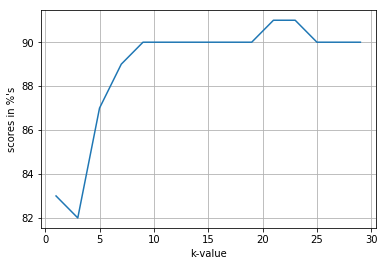

In [37]:
plt.plot(k, scores)
plt.grid()
plt.xlabel('k-value')
plt.ylabel("scores in %'s")
plt.show()

Observation: the plot show's that at k=9 prediction on cross validation data shows maximum score. we can see at k=19 the score is more the 90% but their is a chance of under fitting. So, I take 9 as my hyper parameter. 

In [38]:
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors=9,algorithm='brute')


knn.fit(train_bow, train_scores)

predicted_labels = []
for j in range(0, 20000, 1000):
    predicted_labels.extend(knn.predict(test_bow[j: j+1000]))
    
predicted_labels = np.array(predicted_labels)

predicted_labels=predicted_labels.reshape(20000,)
    
confusion_matrix(test_scores, predicted_labels)# * float(100)


array([[  718,  2662],
       [  615, 16005]], dtype=int64)

Observation: In the above confusion matrix,                                                                                  
->the % correctly predicted positive's is 85.7%,                                                                                 ->the % correctly predicted negative's is 53.8%.

In [45]:
scores = []
k=[]
for i in tqdm(range(1,20,2)):
   
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    knn.fit(train_bow_kd, train_scores)

    predicted_labels = []
    for j in tqdm(range(0, 20000, 1000)):
        predicted_labels.extend(knn.predict(cv_bow_kd[j: j+1000]))
    
    predicted_labels = np.array(predicted_labels)

    predicted_labels=predicted_labels.reshape(20000,)
    
    score = f1_score(cv_scores, predicted_labels) * float(100)
    
    scores.append(int(score))
    k.append(i)




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  5%|████                                                                            | 1/20 [07:18<2:18:42, 438.00s/it]



 10%|████████                                                                        | 2/20 [14:53<2:12:59, 443.29s/it]



 15%|████████████                                                                    | 3/20 [23:41<2:12:44, 468.51s/it]



 20%|████████████████                                                                | 4/20 [32:19<2:08:58, 483.63s/it]



 25%|████████████████████                                                            | 5/20 [39:42<1:57:49, 471.31s/it]



 30%|████████████████████████                                                        | 6/20 [46:42<1:46:22, 455.87s/it]



 35%|████████

 30%|██████████████████████▊                                                     | 3/10 [7:03:04<16:32:17, 8505.33s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  5%|████                                                                            | 1/20 [06:55<2:11:27, 415.15s/it]



 10%|████████                                                                        | 2/20 [13:48<2:04:22, 414.57s/it]



 15%|████████████                                                                    | 3/20 [20:43<1:57:30, 414.76s/it]



 20%|████████████████                                                                | 4/20 [27:59<1:52:18, 421.15s/it]



 25%|████████████████████                                                            | 5/20 [35:23<1:46:58, 427.90s/it]



 30%|████████████████████████                                                        | 6/20 [42:35<1:40:08, 429.15s/it]



 35%|███████████

 60%|█████████████████████████████████████████████                              | 6/10 [15:24:46<10:41:30, 9622.70s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  5%|████                                                                            | 1/20 [14:01<4:26:35, 841.88s/it]



 10%|████████                                                                        | 2/20 [22:39<3:43:24, 744.67s/it]



 15%|████████████                                                                    | 3/20 [31:13<3:11:21, 675.40s/it]



 20%|████████████████                                                                | 4/20 [39:38<2:46:28, 624.27s/it]



 25%|████████████████████                                                            | 5/20 [49:44<2:34:41, 618.79s/it]



 30%|████████████████████████                                                        | 6/20 [59:37<2:22:36, 611.20s/it]



 35%|███████████

 90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [24:02:02<2:48:29, 10109.75s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  5%|████                                                                            | 1/20 [07:03<2:14:01, 423.22s/it]



 10%|████████                                                                        | 2/20 [14:09<2:07:16, 424.27s/it]



 15%|████████████                                                                    | 3/20 [21:18<2:00:31, 425.41s/it]



 20%|████████████████                                                                | 4/20 [28:49<1:55:29, 433.11s/it]



 25%|████████████████████                                                            | 5/20 [36:16<1:49:19, 437.30s/it]



 30%|████████████████████████                                                        | 6/20 [43:40<1:42:33, 439.53s/it]



 35%|███████████

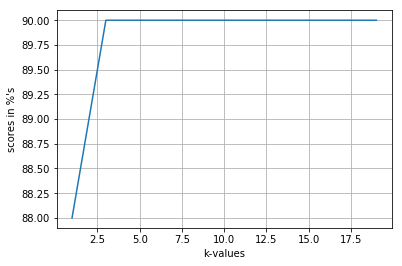

In [46]:
plt.plot(k, scores)
plt.xlabel("k-values")
plt.ylabel("scores in %'s")
plt.grid()
plt.show()

Observation: the plot show's that at k=3 prediction on cross validation data shows maximum score 90%.

In [60]:
knn = KNeighborsClassifier(n_neighbors=3,algorithm='kd_tree')


knn.fit(train_bow_kd, train_scores)

predicted_labels = []
for j in range(0, 20000, 1000):
    predicted_labels.extend(knn.predict(test_bow_kd[j: j+1000]))

predicted_labels = np.array(predicted_labels)

predicted_labels=predicted_labels.reshape(20000,)

confusion_matrix(test_scores, predicted_labels)

array([[  655,  2725],
       [  685, 15935]], dtype=int64)

Observation: In the above confusion matrix,                                                                                  
->the % correctly predicted positive's is 85.3%,  
->the % correctly predicted negative's is 48.8%.

# Tf-idf:

In [52]:
tf_idf_vect = TfidfVectorizer()
train_tf_idf = tf_idf_vect.fit_transform(train['CleanedText'].values)
cv_tf_idf = tf_idf_vect.transform(cv['CleanedText'].values)
test_tf_idf = tf_idf_vect.transform(test['CleanedText'].values)

In [53]:
scores = []
k=[]
for i in tqdm(range(1,30,2)):
    
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    
    knn.fit(train_tf_idf, train_scores)

    predicted_labels = []
    for j in tqdm(range(0, 20000, 1000)):
        predicted_labels.extend(knn.predict(cv_tf_idf[j: j+1000]))
    
    predicted_labels = np.array(predicted_labels)

    predicted_labels=predicted_labels.reshape(20000,)
    
    score = f1_score(cv_scores, predicted_labels) * float(100)
    
    scores.append(int(score))
    k.append(i)




  0%|                                                                                           | 0/15 [00:00<?, ?it/s]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  5%|████▏                                                                              | 1/20 [00:09<03:03,  9.67s/it]



 10%|████████▎                                                                          | 2/20 [00:15<02:32,  8.46s/it]



 15%|████████████▍                                                                      | 3/20 [00:20<02:06,  7.47s/it]



 20%|████████████████▌                                                                  | 4/20 [00:25<01:47,  6.72s/it]



 25%|████████████████████▊                                                              | 5/20 [00:30<01:32,  6.18s/it]



 30%|████████████████████████▉                                                          | 6/20 [00:35<01:21,  5.82s/it]



 35%|████████

 20%|████████████████▍                                                                 | 3/15 [06:47<26:48, 134.04s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  5%|████▏                                                                              | 1/20 [00:06<01:55,  6.06s/it]



 10%|████████▎                                                                          | 2/20 [00:11<01:48,  6.01s/it]



 15%|████████████▍                                                                      | 3/20 [00:19<01:51,  6.54s/it]



 20%|████████████████▌                                                                  | 4/20 [00:25<01:41,  6.34s/it]



 25%|████████████████████▊                                                              | 5/20 [00:32<01:35,  6.40s/it]



 30%|████████████████████████▉                                                          | 6/20 [00:38<01:29,  6.37s/it]



 35%|███████████

 40%|████████████████████████████████▊                                                 | 6/15 [14:04<20:48, 138.73s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  5%|████▏                                                                              | 1/20 [00:05<01:47,  5.67s/it]



 10%|████████▎                                                                          | 2/20 [00:11<01:41,  5.66s/it]



 15%|████████████▍                                                                      | 3/20 [00:16<01:36,  5.66s/it]



 20%|████████████████▌                                                                  | 4/20 [00:22<01:30,  5.64s/it]



 25%|████████████████████▊                                                              | 5/20 [00:28<01:24,  5.61s/it]



 30%|████████████████████████▉                                                          | 6/20 [00:33<01:18,  5.63s/it]



 35%|███████████

 60%|█████████████████████████████████████████████████▏                                | 9/15 [19:45<12:13, 122.27s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  5%|████▏                                                                              | 1/20 [00:05<01:48,  5.70s/it]



 10%|████████▎                                                                          | 2/20 [00:11<01:42,  5.69s/it]



 15%|████████████▍                                                                      | 3/20 [00:17<01:36,  5.70s/it]



 20%|████████████████▌                                                                  | 4/20 [00:22<01:30,  5.66s/it]



 25%|████████████████████▊                                                              | 5/20 [00:28<01:25,  5.67s/it]



 30%|████████████████████████▉                                                          | 6/20 [00:34<01:20,  5.72s/it]



 35%|███████████

 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [25:21<05:45, 115.07s/it]



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]



  5%|████▏                                                                              | 1/20 [00:05<01:45,  5.53s/it]



 10%|████████▎                                                                          | 2/20 [00:10<01:39,  5.50s/it]



 15%|████████████▍                                                                      | 3/20 [00:16<01:33,  5.50s/it]



 20%|████████████████▌                                                                  | 4/20 [00:21<01:27,  5.47s/it]



 25%|████████████████████▊                                                              | 5/20 [00:27<01:21,  5.43s/it]



 30%|████████████████████████▉                                                          | 6/20 [00:32<01:16,  5.45s/it]



 35%|███████████

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [30:50<00:00, 111.46s/it]




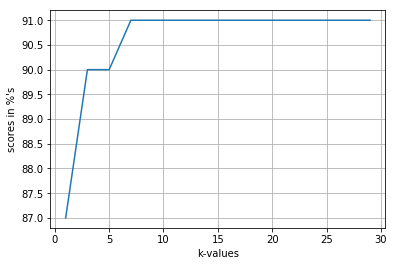

In [54]:
plt.plot(k, scores)
plt.xlabel("k-values")
plt.ylabel("scores in %'s")
plt.grid()
plt.show()

Observation: the plot show's that at k=7 prediction on cross validation data shows maximum score 91%.

In [61]:
knn = KNeighborsClassifier(n_neighbors=7,algorithm='brute')


knn.fit(train_tf_idf, train_scores)

predicted_labels = []
for j in tqdm(range(0, 20000, 1000)):
    predicted_labels.extend(knn.predict(test_tf_idf[j: j+1000]))
    
predicted_labels = np.array(predicted_labels)

predicted_labels=predicted_labels.reshape(20000,)

confusion_matrix(test_scores, predicted_labels)






  0%|                                                                                           | 0/20 [00:00<?, ?it/s]




  5%|████▏                                                                              | 1/20 [00:06<02:00,  6.32s/it]




 10%|████████▎                                                                          | 2/20 [00:12<01:51,  6.20s/it]




 15%|████████████▍                                                                      | 3/20 [00:18<01:45,  6.22s/it]




 20%|████████████████▌                                                                  | 4/20 [00:24<01:39,  6.21s/it]




 25%|████████████████████▊                                                              | 5/20 [00:30<01:33,  6.22s/it]




 30%|████████████████████████▉                                                          | 6/20 [00:37<01:28,  6.31s/it]




 35%|█████████████████████████████                                                      | 7/20 [00:43<01:21,  6.28s/it]




 40

array([[  716,  2664],
       [  365, 16255]], dtype=int64)

Observation: In the above confusion matrix,                                                                                  
->the % correctly predicted positive's is 85.9%,  
->the % correctly predicted negative's is 66.2%.

In [55]:
tfidf_vect = TfidfVectorizer(min_df=50, max_features=2000)
train_tfidf = tfidf_vect.fit_transform(train['CleanedText'].values)
cv_tfidf = tfidf_vect.transform(cv['CleanedText'].values)
test_tfidf = tfidf_vect.transform(test['CleanedText'].values)
import scipy
train_tfidf_kd = train_tfidf.toarray()
cv_tfidf_kd = cv_tfidf.toarray()
test_tfidf_kd = test_tfidf.toarray() 

In [58]:
scores = []
k=[]
for i in tqdm(range(1,14,2)):
    
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    
    knn.fit(train_tfidf_kd, train_scores)

    predicted_labels = []
    for j in tqdm(range(0, 20000, 1000)):
        predicted_labels.extend(knn.predict(cv_tfidf_kd[j: j+1000]))
        
    predicted_labels = np.array(predicted_labels)

    predicted_labels=predicted_labels.reshape(20000,)
        
    score = f1_score(cv_scores, predicted_labels) * float(100)
    
    scores.append(int(score))
    k.append(i)






  0%|                                                                                            | 0/7 [00:00<?, ?it/s]





  0%|                                                                                           | 0/20 [00:00<?, ?it/s]





  5%|████                                                                            | 1/20 [07:16<2:18:15, 436.60s/it]





 10%|████████                                                                        | 2/20 [14:26<2:10:20, 434.48s/it]





 15%|████████████                                                                    | 3/20 [21:32<2:02:26, 432.13s/it]





 20%|████████████████                                                                | 4/20 [28:52<1:55:52, 434.50s/it]





 25%|████████████████████                                                            | 5/20 [35:54<1:47:40, 430.71s/it]





 30%|████████████████████████                                                        | 6/20 [42:58<1:39:59, 428.54s/it]


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:23:07<00:00, 474.24s/it]










 43%|█████████████████████████████████▍                                            | 3/7 [7:08:59<9:28:54, 8533.60s/it]





  0%|                                                                                           | 0/20 [00:00<?, ?it/s]





  5%|████                                                                            | 1/20 [10:03<3:11:09, 603.66s/it]





 10%|████████                                                                        | 2/20 [20:33<3:03:29, 611.63s/it]





 15%|████████████                                                                    | 3/20 [30:19<2:51:04, 603.80s/it]





 20%|████████████████                                                                | 4/20 [39:55<2:38:49, 595.59s/it]





 25%|████████████████████                                                            | 5/20 [49:03<2:25:16, 581.11s/it]


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [2:11:27<06:55, 415.22s/it]





100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:18:24<00:00, 415.93s/it]










 86%|██████████████████████████████████████████████████████████████████           | 6/7 [14:47:51<2:26:19, 8779.91s/it]





  0%|                                                                                           | 0/20 [00:00<?, ?it/s]





  5%|████                                                                            | 1/20 [06:54<2:11:18, 414.64s/it]





 10%|████████                                                                        | 2/20 [13:49<2:04:23, 414.61s/it]





 15%|████████████                                                                    | 3/20 [20:44<1:57:31, 414.77s/it]





 20%|████████████████                                                                | 4/20 [27:40<1:50:41, 415.08s/it]


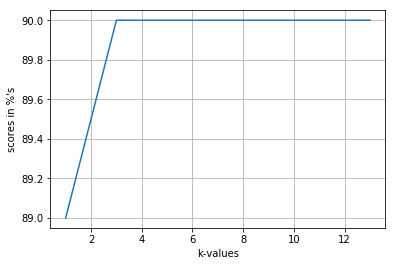

In [59]:
plt.plot(k, scores)
plt.xlabel("k-values")
plt.ylabel("scores in %'s")
plt.grid()
plt.show()

Observation: the plot show's that at k=3 prediction on cross validation data shows maximum score 90%.

In [62]:
knn = KNeighborsClassifier(n_neighbors=3,algorithm='kd_tree')


knn.fit(train_tfidf_kd, train_scores)

predicted_labels = []
for j in range(0, 20000, 1000):
    predicted_labels.extend(knn.predict(test_tfidf_kd[j: j+1000]))
    
predicted_labels = np.array(predicted_labels)

predicted_labels=predicted_labels.reshape(20000,)

confusion_matrix(test_scores, predicted_labels)

array([[  104,  3276],
       [  157, 16463]], dtype=int64)

Observation: In the above confusion matrix,                                                                                  
->the % correctly predicted positive's is 83.4%,  
->the % correctly predicted negative's is 48.1%.

# Training using W2v:

In [84]:
import gensim

In [65]:
i=0
train_w2v_list=[]
for sent in tqdm(train['CleanedText'].values):
    train_w2v_list.append(sent.split())
print("*****cv******")    
i=0
cv_w2v_list=[]
for sent in tqdm(cv['CleanedText'].values):
    cv_w2v_list.append(sent.split())
print("*****test******")    
i=0
test_w2v_list=[]
for sent in tqdm(test['CleanedText'].values):
    test_w2v_list.append(sent.split())    







  0%|                                                                                        | 0/60000 [00:00<?, ?it/s]





  2%|█▊                                                                        | 1456/60000 [00:00<00:04, 14454.11it/s]





 10%|███████▎                                                                  | 5887/60000 [00:00<00:03, 18033.80it/s]





 16%|███████████▌                                                              | 9417/60000 [00:00<00:02, 21107.41it/s]





 24%|█████████████████▏                                                       | 14139/60000 [00:00<00:01, 25275.89it/s]





 33%|███████████████████████▉                                                 | 19666/60000 [00:00<00:01, 30154.96it/s]





 39%|████████████████████████████▍                                            | 23356/60000 [00:00<00:01, 28691.31it/s]




 61%|█████████████████████████████████████████████▋                             | 36573/60000 [01:31<03:20, 117.03it/s]


*****cv******








  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]





 12%|█████████▏                                                                | 2499/20000 [00:00<00:00, 24928.45it/s]





 20%|██████████████▌                                                           | 3935/20000 [00:00<00:00, 20141.79it/s]





 36%|██████████████████████████▎                                               | 7122/20000 [00:00<00:00, 22606.19it/s]





 46%|█████████████████████████████████▉                                        | 9173/20000 [00:00<00:00, 21776.18it/s]





 55%|███████████████████████████████████████▉                                 | 10946/20000 [00:00<00:00, 19523.24it/s]





 72%|████████████████████████████████████████████████████▏                    | 14300/20000 [00:00<00:00, 22289.22it/s]





 84%|█████████████████████████████████████████████████████████████▍           | 16844/20000 [00:00<00:00, 22640.70it/s]

*****test******








  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]





 20%|██████████████▍                                                           | 3910/20000 [00:00<00:00, 38816.75it/s]





 33%|████████████████████████▍                                                 | 6595/20000 [00:00<00:00, 34201.87it/s]





 41%|██████████████████████████████▊                                            | 8214/20000 [00:00<00:01, 7511.80it/s]





 50%|█████████████████████████████████████▏                                    | 10067/20000 [00:00<00:01, 8961.05it/s]





 58%|██████████████████████████████████████████▌                              | 11650/20000 [00:01<00:00, 10227.77it/s]





 67%|████████████████████████████████████████████████▌                        | 13305/20000 [00:01<00:00, 11462.28it/s]





 76%|███████████████████████████████████████████████████████▋                 | 15264/20000 [00:01<00:00, 12728.03it/s]

In [66]:
#training the train,cv,test data list with the words occuring minimum 5 times 
train_w2v=Word2Vec(train_w2v_list,min_count=5,size=50, workers=2)
cv_w2v=Word2Vec(cv_w2v_list,min_count=5,size=50, workers=2)
test_w2v=Word2Vec(test_w2v_list,min_count=5,size=50, workers=2)

In [67]:
train_w2v_words = list(train_w2v.wv.vocab)
cv_w2v_words = list(cv_w2v.wv.vocab)
test_w2v_words = list(test_w2v.wv.vocab)

# Average weighted w2v:

In [68]:
avg_w2v_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(train_w2v_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in train_w2v_words:
            vec = train_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_w2v_train.append(sent_vec)







  0%|                                                                                        | 0/60000 [00:00<?, ?it/s]





  0%|                                                                              | 36/60000 [00:00<02:46, 359.12it/s]





  0%|                                                                              | 64/60000 [00:00<03:02, 329.00it/s]





  0%|▏                                                                            | 110/60000 [00:00<02:47, 357.45it/s]





  0%|▏                                                                            | 135/60000 [00:00<03:11, 313.29it/s]





  0%|▏                                                                            | 160/60000 [00:00<03:33, 280.67it/s]





  0%|▏                                                                            | 192/60000 [00:00<03:26, 289.27it/s]





  0%|▎                                                                            | 222/60000 [00:00<03:27, 288.42it/s]

  2%|█▋                                                                          | 1365/60000 [00:08<06:18, 155.08it/s]





  2%|█▊                                                                          | 1391/60000 [00:08<05:34, 175.11it/s]





  2%|█▊                                                                          | 1411/60000 [00:08<05:58, 163.35it/s]





  2%|█▊                                                                          | 1430/60000 [00:08<06:07, 159.51it/s]





  2%|█▊                                                                          | 1448/60000 [00:08<06:42, 145.63it/s]





  2%|█▊                                                                          | 1478/60000 [00:08<05:40, 172.00it/s]





  3%|█▉                                                                          | 1501/60000 [00:09<06:04, 160.53it/s]





  3%|█▉                                                                          | 1520/60000 [00:09<06:02, 161.21it/s]







  5%|███▊                                                                        | 2968/60000 [00:17<05:57, 159.42it/s]





  5%|███▊                                                                        | 2988/60000 [00:17<05:39, 168.14it/s]





  5%|███▊                                                                        | 3008/60000 [00:17<05:23, 176.24it/s]





  5%|███▊                                                                        | 3027/60000 [00:17<05:30, 172.46it/s]





  5%|███▊                                                                        | 3045/60000 [00:17<05:40, 167.25it/s]





  5%|███▉                                                                        | 3063/60000 [00:17<06:38, 142.97it/s]





  5%|███▉                                                                        | 3079/60000 [00:17<06:41, 141.91it/s]





  5%|███▉                                                                        | 3094/60000 [00:17<06:56, 136.63it/s]







  8%|██████▎                                                                     | 4967/60000 [00:24<03:43, 245.87it/s]





  8%|██████▎                                                                     | 4992/60000 [00:24<03:52, 236.11it/s]





  8%|██████▎                                                                     | 5023/60000 [00:24<03:38, 251.97it/s]





  8%|██████▍                                                                     | 5049/60000 [00:24<04:10, 219.19it/s]





  8%|██████▍                                                                     | 5073/60000 [00:24<04:13, 216.69it/s]





  9%|██████▍                                                                     | 5104/60000 [00:25<03:50, 237.80it/s]





  9%|██████▍                                                                     | 5129/60000 [00:25<04:04, 224.64it/s]





  9%|██████▌                                                                     | 5174/60000 [00:25<03:28, 262.63it/s]







 11%|████████▋                                                                   | 6832/60000 [00:31<03:32, 250.17it/s]





 11%|████████▋                                                                   | 6858/60000 [00:32<03:49, 231.94it/s]





 11%|████████▋                                                                   | 6883/60000 [00:32<03:46, 234.59it/s]





 12%|████████▊                                                                   | 6910/60000 [00:32<03:37, 243.72it/s]





 12%|████████▊                                                                   | 6935/60000 [00:32<03:47, 232.75it/s]





 12%|████████▊                                                                   | 6967/60000 [00:32<03:35, 246.63it/s]





 12%|████████▊                                                                   | 6993/60000 [00:32<03:33, 248.54it/s]





 12%|████████▉                                                                   | 7028/60000 [00:32<03:18, 267.40it/s]







 15%|███████████                                                                 | 8778/60000 [00:39<04:26, 192.32it/s]





 15%|███████████▏                                                                | 8810/60000 [00:39<03:54, 218.36it/s]





 15%|███████████▏                                                                | 8834/60000 [00:39<03:58, 214.97it/s]





 15%|███████████▏                                                                | 8857/60000 [00:39<04:15, 200.28it/s]





 15%|███████████▏                                                                | 8881/60000 [00:39<04:02, 210.60it/s]





 15%|███████████▎                                                                | 8905/60000 [00:39<03:56, 215.85it/s]





 15%|███████████▎                                                                | 8928/60000 [00:40<04:10, 203.74it/s]





 15%|███████████▎                                                                | 8960/60000 [00:40<03:44, 227.82it/s]







 18%|█████████████▏                                                             | 10529/60000 [00:46<03:49, 215.30it/s]





 18%|█████████████▏                                                             | 10556/60000 [00:46<03:37, 227.07it/s]





 18%|█████████████▏                                                             | 10580/60000 [00:47<03:57, 207.66it/s]





 18%|█████████████▎                                                             | 10603/60000 [00:47<03:51, 213.46it/s]





 18%|█████████████▎                                                             | 10635/60000 [00:47<03:37, 227.20it/s]





 18%|█████████████▎                                                             | 10664/60000 [00:47<03:23, 242.54it/s]





 18%|█████████████▎                                                             | 10689/60000 [00:47<03:26, 238.28it/s]





 18%|█████████████▍                                                             | 10714/60000 [00:47<03:32, 231.47it/s]







 20%|███████████████▎                                                           | 12285/60000 [00:54<04:02, 196.40it/s]





 21%|███████████████▍                                                           | 12307/60000 [00:54<03:55, 202.52it/s]





 21%|███████████████▍                                                           | 12329/60000 [00:54<03:55, 202.46it/s]





 21%|███████████████▍                                                           | 12366/60000 [00:54<03:23, 233.52it/s]





 21%|███████████████▍                                                           | 12395/60000 [00:54<03:12, 247.63it/s]





 21%|███████████████▌                                                           | 12431/60000 [00:54<02:54, 272.14it/s]





 21%|███████████████▌                                                           | 12461/60000 [00:54<02:53, 274.39it/s]





 21%|███████████████▌                                                           | 12494/60000 [00:54<02:44, 288.45it/s]







 24%|█████████████████▉                                                         | 14335/60000 [01:01<03:05, 246.57it/s]





 24%|█████████████████▉                                                         | 14364/60000 [01:01<02:57, 257.67it/s]





 24%|█████████████████▉                                                         | 14392/60000 [01:02<03:01, 250.74it/s]





 24%|██████████████████                                                         | 14426/60000 [01:02<02:47, 272.01it/s]





 24%|██████████████████                                                         | 14454/60000 [01:02<03:07, 243.18it/s]





 24%|██████████████████                                                         | 14480/60000 [01:02<03:15, 232.89it/s]





 24%|██████████████████▏                                                        | 14515/60000 [01:02<02:56, 257.32it/s]





 24%|██████████████████▏                                                        | 14551/60000 [01:02<02:42, 278.96it/s]







 27%|████████████████████▍                                                      | 16313/60000 [01:09<03:07, 232.93it/s]





 27%|████████████████████▍                                                      | 16339/60000 [01:09<03:11, 227.99it/s]





 27%|████████████████████▍                                                      | 16364/60000 [01:09<03:14, 224.89it/s]





 27%|████████████████████▍                                                      | 16388/60000 [01:09<03:10, 229.06it/s]





 27%|████████████████████▌                                                      | 16423/60000 [01:09<02:55, 248.63it/s]





 27%|████████████████████▌                                                      | 16464/60000 [01:09<02:34, 281.50it/s]





 27%|████████████████████▌                                                      | 16495/60000 [01:10<02:52, 251.70it/s]





 28%|████████████████████▋                                                      | 16544/60000 [01:10<02:27, 294.30it/s]







 30%|██████████████████████▋                                                    | 18182/60000 [01:16<02:40, 260.60it/s]





 30%|██████████████████████▊                                                    | 18221/60000 [01:16<02:26, 285.45it/s]





 30%|██████████████████████▊                                                    | 18251/60000 [01:17<02:58, 233.51it/s]





 30%|██████████████████████▊                                                    | 18294/60000 [01:17<02:34, 269.72it/s]





 31%|██████████████████████▉                                                    | 18325/60000 [01:17<02:28, 280.11it/s]





 31%|██████████████████████▉                                                    | 18357/60000 [01:17<02:23, 290.41it/s]





 31%|██████████████████████▉                                                    | 18391/60000 [01:17<02:17, 303.11it/s]





 31%|███████████████████████                                                    | 18423/60000 [01:17<02:26, 283.69it/s]







 33%|████████████████████████▊                                                  | 19808/60000 [01:24<05:44, 116.79it/s]





 33%|████████████████████████▊                                                  | 19828/60000 [01:24<05:07, 130.65it/s]





 33%|████████████████████████▊                                                  | 19843/60000 [01:25<05:37, 119.04it/s]





 33%|████████████████████████▊                                                  | 19857/60000 [01:25<05:39, 118.11it/s]





 33%|████████████████████████▊                                                  | 19877/60000 [01:25<04:59, 134.18it/s]





 33%|████████████████████████▉                                                  | 19903/60000 [01:25<04:16, 156.20it/s]





 33%|████████████████████████▉                                                  | 19922/60000 [01:25<04:04, 163.84it/s]





 33%|████████████████████████▉                                                  | 19954/60000 [01:25<03:30, 190.66it/s]







 36%|██████████████████████████▊                                                | 21466/60000 [01:32<02:41, 239.28it/s]





 36%|██████████████████████████▊                                                | 21491/60000 [01:32<02:52, 223.15it/s]





 36%|██████████████████████████▉                                                | 21518/60000 [01:32<02:45, 232.53it/s]





 36%|██████████████████████████▉                                                | 21542/60000 [01:32<02:46, 230.85it/s]





 36%|██████████████████████████▉                                                | 21569/60000 [01:32<02:39, 240.84it/s]





 36%|██████████████████████████▉                                                | 21594/60000 [01:32<02:40, 239.52it/s]





 36%|███████████████████████████                                                | 21624/60000 [01:32<02:31, 253.18it/s]





 36%|███████████████████████████                                                | 21650/60000 [01:33<02:34, 248.10it/s]







 39%|████████████████████████████▉                                              | 23138/60000 [01:39<02:39, 231.20it/s]





 39%|████████████████████████████▉                                              | 23163/60000 [01:39<02:44, 223.43it/s]





 39%|████████████████████████████▉                                              | 23192/60000 [01:40<02:43, 224.53it/s]





 39%|█████████████████████████████                                              | 23217/60000 [01:40<02:40, 229.24it/s]





 39%|█████████████████████████████                                              | 23241/60000 [01:40<02:39, 230.86it/s]





 39%|█████████████████████████████                                              | 23268/60000 [01:40<02:36, 235.23it/s]





 39%|█████████████████████████████                                              | 23297/60000 [01:40<02:27, 248.56it/s]





 39%|█████████████████████████████▏                                             | 23323/60000 [01:40<02:33, 239.57it/s]







 41%|██████████████████████████████▉                                            | 24780/60000 [01:47<02:56, 199.24it/s]





 41%|███████████████████████████████                                            | 24802/60000 [01:47<03:06, 188.86it/s]





 41%|███████████████████████████████                                            | 24824/60000 [01:47<02:58, 196.57it/s]





 41%|███████████████████████████████                                            | 24848/60000 [01:47<02:54, 201.46it/s]





 41%|███████████████████████████████                                            | 24872/60000 [01:47<02:46, 211.25it/s]





 42%|███████████████████████████████▏                                           | 24902/60000 [01:47<02:33, 228.27it/s]





 42%|███████████████████████████████▏                                           | 24943/60000 [01:47<02:15, 259.43it/s]





 42%|███████████████████████████████▏                                           | 24971/60000 [01:48<02:31, 231.35it/s]







 44%|█████████████████████████████████▏                                         | 26534/60000 [01:55<03:00, 185.34it/s]





 44%|█████████████████████████████████▏                                         | 26560/60000 [01:55<02:46, 200.34it/s]





 44%|█████████████████████████████████▏                                         | 26589/60000 [01:55<02:33, 217.97it/s]





 44%|█████████████████████████████████▎                                         | 26613/60000 [01:55<02:36, 213.56it/s]





 44%|█████████████████████████████████▎                                         | 26639/60000 [01:55<02:28, 224.06it/s]





 44%|█████████████████████████████████▎                                         | 26663/60000 [01:55<02:32, 218.81it/s]





 44%|█████████████████████████████████▎                                         | 26689/60000 [01:55<02:25, 228.68it/s]





 45%|█████████████████████████████████▍                                         | 26713/60000 [01:55<02:24, 230.80it/s]







 47%|███████████████████████████████████▎                                       | 28286/60000 [02:02<02:22, 221.87it/s]





 47%|███████████████████████████████████▍                                       | 28309/60000 [02:02<02:28, 213.22it/s]





 47%|███████████████████████████████████▍                                       | 28340/60000 [02:02<02:15, 233.28it/s]





 47%|███████████████████████████████████▍                                       | 28365/60000 [02:03<02:17, 229.72it/s]





 47%|███████████████████████████████████▍                                       | 28389/60000 [02:03<02:22, 221.32it/s]





 47%|███████████████████████████████████▌                                       | 28412/60000 [02:03<02:22, 221.45it/s]





 47%|███████████████████████████████████▌                                       | 28446/60000 [02:03<02:08, 245.33it/s]





 47%|███████████████████████████████████▌                                       | 28472/60000 [02:03<02:26, 214.59it/s]







 50%|█████████████████████████████████████▋                                     | 30181/60000 [02:10<02:39, 187.46it/s]





 50%|█████████████████████████████████████▊                                     | 30202/60000 [02:10<02:36, 190.68it/s]





 50%|█████████████████████████████████████▊                                     | 30223/60000 [02:10<02:33, 193.79it/s]





 50%|█████████████████████████████████████▊                                     | 30244/60000 [02:10<02:51, 173.08it/s]





 50%|█████████████████████████████████████▊                                     | 30268/60000 [02:10<02:38, 187.01it/s]





 50%|█████████████████████████████████████▊                                     | 30288/60000 [02:10<02:39, 185.82it/s]





 51%|█████████████████████████████████████▉                                     | 30328/60000 [02:11<02:15, 218.40it/s]





 51%|█████████████████████████████████████▉                                     | 30353/60000 [02:11<02:20, 211.64it/s]







 53%|███████████████████████████████████████▉                                   | 31975/60000 [02:17<02:10, 215.33it/s]





 53%|███████████████████████████████████████▉                                   | 31997/60000 [02:18<02:16, 205.37it/s]





 53%|████████████████████████████████████████                                   | 32023/60000 [02:18<02:08, 218.23it/s]





 53%|████████████████████████████████████████                                   | 32046/60000 [02:18<02:10, 214.98it/s]





 53%|████████████████████████████████████████                                   | 32068/60000 [02:18<02:12, 210.44it/s]





 54%|████████████████████████████████████████▏                                  | 32101/60000 [02:18<01:58, 235.23it/s]





 54%|████████████████████████████████████████▏                                  | 32126/60000 [02:18<02:05, 222.72it/s]





 54%|████████████████████████████████████████▏                                  | 32152/60000 [02:18<02:00, 231.34it/s]







 56%|██████████████████████████████████████████▎                                | 33812/60000 [02:25<02:07, 205.28it/s]





 56%|██████████████████████████████████████████▎                                | 33836/60000 [02:25<02:02, 213.04it/s]





 56%|██████████████████████████████████████████▎                                | 33861/60000 [02:25<01:57, 222.49it/s]





 56%|██████████████████████████████████████████▎                                | 33885/60000 [02:25<01:55, 226.03it/s]





 57%|██████████████████████████████████████████▍                                | 33918/60000 [02:25<01:44, 248.92it/s]





 57%|██████████████████████████████████████████▍                                | 33944/60000 [02:25<01:47, 243.16it/s]





 57%|██████████████████████████████████████████▍                                | 33971/60000 [02:25<01:45, 247.38it/s]





 57%|██████████████████████████████████████████▍                                | 33997/60000 [02:26<02:00, 216.22it/s]







 59%|████████████████████████████████████████████▎                              | 35492/60000 [02:32<02:08, 190.79it/s]





 59%|████████████████████████████████████████████▍                              | 35524/60000 [02:32<01:53, 215.02it/s]





 59%|████████████████████████████████████████████▍                              | 35548/60000 [02:33<02:15, 181.01it/s]





 59%|████████████████████████████████████████████▍                              | 35577/60000 [02:33<02:01, 201.78it/s]





 59%|████████████████████████████████████████████▌                              | 35600/60000 [02:33<02:07, 192.09it/s]





 59%|████████████████████████████████████████████▌                              | 35621/60000 [02:33<02:10, 186.29it/s]





 59%|████████████████████████████████████████████▌                              | 35652/60000 [02:33<01:55, 210.88it/s]





 59%|████████████████████████████████████████████▌                              | 35686/60000 [02:33<01:43, 235.17it/s]







 62%|██████████████████████████████████████████████▍                            | 37173/60000 [02:40<01:37, 233.66it/s]





 62%|██████████████████████████████████████████████▍                            | 37199/60000 [02:40<01:52, 201.93it/s]





 62%|██████████████████████████████████████████████▌                            | 37233/60000 [02:40<01:39, 229.60it/s]





 62%|██████████████████████████████████████████████▌                            | 37259/60000 [02:40<01:37, 233.02it/s]





 62%|██████████████████████████████████████████████▌                            | 37288/60000 [02:40<01:32, 245.27it/s]





 62%|██████████████████████████████████████████████▋                            | 37315/60000 [02:40<01:32, 244.86it/s]





 62%|██████████████████████████████████████████████▋                            | 37341/60000 [02:41<01:36, 235.23it/s]





 62%|██████████████████████████████████████████████▋                            | 37379/60000 [02:41<01:25, 264.34it/s]







 65%|████████████████████████████████████████████████▉                          | 39112/60000 [02:47<01:54, 182.03it/s]





 65%|████████████████████████████████████████████████▉                          | 39131/60000 [02:48<01:57, 178.28it/s]





 65%|████████████████████████████████████████████████▉                          | 39166/60000 [02:48<01:39, 208.39it/s]





 65%|████████████████████████████████████████████████▉                          | 39190/60000 [02:48<01:40, 206.50it/s]





 65%|█████████████████████████████████████████████████                          | 39217/60000 [02:48<01:35, 217.97it/s]





 65%|█████████████████████████████████████████████████                          | 39246/60000 [02:48<01:28, 234.24it/s]





 65%|█████████████████████████████████████████████████                          | 39278/60000 [02:48<01:21, 253.36it/s]





 66%|█████████████████████████████████████████████████▏                         | 39306/60000 [02:48<01:19, 259.55it/s]







 68%|███████████████████████████████████████████████████                        | 40891/60000 [02:55<01:17, 245.94it/s]





 68%|███████████████████████████████████████████████████▏                       | 40920/60000 [02:55<01:14, 255.15it/s]





 68%|███████████████████████████████████████████████████▏                       | 40947/60000 [02:55<01:21, 233.44it/s]





 68%|███████████████████████████████████████████████████▏                       | 40972/60000 [02:55<01:22, 230.11it/s]





 68%|███████████████████████████████████████████████████▏                       | 40996/60000 [02:56<01:27, 217.96it/s]





 68%|███████████████████████████████████████████████████▎                       | 41019/60000 [02:56<01:32, 206.16it/s]





 68%|███████████████████████████████████████████████████▎                       | 41041/60000 [02:56<01:34, 201.63it/s]





 68%|███████████████████████████████████████████████████▎                       | 41069/60000 [02:56<01:26, 218.71it/s]







 71%|█████████████████████████████████████████████████████▏                     | 42550/60000 [03:03<01:29, 195.52it/s]





 71%|█████████████████████████████████████████████████████▏                     | 42578/60000 [03:03<01:22, 211.23it/s]





 71%|█████████████████████████████████████████████████████▎                     | 42608/60000 [03:03<01:17, 225.69it/s]





 71%|█████████████████████████████████████████████████████▎                     | 42632/60000 [03:03<01:23, 207.38it/s]





 71%|█████████████████████████████████████████████████████▎                     | 42667/60000 [03:03<01:13, 235.91it/s]





 71%|█████████████████████████████████████████████████████▎                     | 42693/60000 [03:03<01:13, 234.96it/s]





 71%|█████████████████████████████████████████████████████▍                     | 42718/60000 [03:03<01:12, 238.78it/s]





 71%|█████████████████████████████████████████████████████▍                     | 42748/60000 [03:03<01:09, 247.90it/s]







 74%|███████████████████████████████████████████████████████▎                   | 44262/60000 [03:10<01:22, 189.85it/s]





 74%|███████████████████████████████████████████████████████▎                   | 44282/60000 [03:10<01:35, 164.45it/s]





 74%|███████████████████████████████████████████████████████▍                   | 44303/60000 [03:10<01:29, 175.54it/s]





 74%|███████████████████████████████████████████████████████▍                   | 44322/60000 [03:11<01:34, 166.14it/s]





 74%|███████████████████████████████████████████████████████▍                   | 44347/60000 [03:11<01:24, 184.63it/s]





 74%|███████████████████████████████████████████████████████▍                   | 44376/60000 [03:11<01:15, 206.89it/s]





 74%|███████████████████████████████████████████████████████▌                   | 44405/60000 [03:11<01:09, 225.96it/s]





 74%|███████████████████████████████████████████████████████▌                   | 44430/60000 [03:11<01:12, 214.60it/s]







 77%|█████████████████████████████████████████████████████████▌                 | 46075/60000 [03:18<01:00, 229.53it/s]





 77%|█████████████████████████████████████████████████████████▋                 | 46122/60000 [03:18<00:51, 270.81it/s]





 77%|█████████████████████████████████████████████████████████▋                 | 46153/60000 [03:18<00:53, 260.76it/s]





 77%|█████████████████████████████████████████████████████████▋                 | 46182/60000 [03:18<00:54, 254.94it/s]





 77%|█████████████████████████████████████████████████████████▊                 | 46210/60000 [03:18<00:54, 253.64it/s]





 77%|█████████████████████████████████████████████████████████▊                 | 46240/60000 [03:18<00:51, 264.76it/s]





 77%|█████████████████████████████████████████████████████████▊                 | 46273/60000 [03:18<00:49, 274.96it/s]





 77%|█████████████████████████████████████████████████████████▉                 | 46302/60000 [03:19<00:52, 258.64it/s]







 80%|████████████████████████████████████████████████████████████               | 48049/60000 [03:25<00:59, 200.76it/s]





 80%|████████████████████████████████████████████████████████████               | 48071/60000 [03:25<01:03, 188.89it/s]





 80%|████████████████████████████████████████████████████████████               | 48091/60000 [03:25<01:04, 185.31it/s]





 80%|████████████████████████████████████████████████████████████▏              | 48111/60000 [03:26<01:06, 178.49it/s]





 80%|████████████████████████████████████████████████████████████▏              | 48134/60000 [03:26<01:03, 187.49it/s]





 80%|████████████████████████████████████████████████████████████▏              | 48169/60000 [03:26<00:54, 217.73it/s]





 80%|████████████████████████████████████████████████████████████▏              | 48193/60000 [03:26<00:55, 211.71it/s]





 80%|████████████████████████████████████████████████████████████▎              | 48225/60000 [03:26<00:50, 234.22it/s]







 83%|██████████████████████████████████████████████████████████████▌            | 50021/60000 [03:33<00:47, 208.65it/s]





 83%|██████████████████████████████████████████████████████████████▌            | 50051/60000 [03:33<00:43, 227.62it/s]





 83%|██████████████████████████████████████████████████████████████▌            | 50083/60000 [03:33<00:40, 247.33it/s]





 84%|██████████████████████████████████████████████████████████████▋            | 50110/60000 [03:33<00:42, 235.37it/s]





 84%|██████████████████████████████████████████████████████████████▋            | 50137/60000 [03:33<00:40, 243.30it/s]





 84%|██████████████████████████████████████████████████████████████▋            | 50163/60000 [03:33<00:41, 237.73it/s]





 84%|██████████████████████████████████████████████████████████████▋            | 50195/60000 [03:33<00:38, 256.83it/s]





 84%|██████████████████████████████████████████████████████████████▊            | 50250/60000 [03:33<00:31, 305.59it/s]







 87%|█████████████████████████████████████████████████████████████████          | 52070/60000 [03:40<00:35, 221.71it/s]





 87%|█████████████████████████████████████████████████████████████████          | 52099/60000 [03:41<00:33, 237.83it/s]





 87%|█████████████████████████████████████████████████████████████████▏         | 52125/60000 [03:41<00:38, 204.10it/s]





 87%|█████████████████████████████████████████████████████████████████▏         | 52162/60000 [03:41<00:33, 235.49it/s]





 87%|█████████████████████████████████████████████████████████████████▏         | 52197/60000 [03:41<00:30, 258.39it/s]





 87%|█████████████████████████████████████████████████████████████████▎         | 52226/60000 [03:41<00:32, 236.07it/s]





 87%|█████████████████████████████████████████████████████████████████▎         | 52253/60000 [03:41<00:31, 243.51it/s]





 87%|█████████████████████████████████████████████████████████████████▎         | 52280/60000 [03:41<00:30, 249.69it/s]







 90%|███████████████████████████████████████████████████████████████████▍       | 53927/60000 [03:48<00:26, 233.11it/s]





 90%|███████████████████████████████████████████████████████████████████▍       | 53959/60000 [03:48<00:24, 247.76it/s]





 90%|███████████████████████████████████████████████████████████████████▍       | 53985/60000 [03:48<00:24, 247.52it/s]





 90%|███████████████████████████████████████████████████████████████████▌       | 54017/60000 [03:48<00:22, 263.77it/s]





 90%|███████████████████████████████████████████████████████████████████▌       | 54045/60000 [03:48<00:25, 235.52it/s]





 90%|███████████████████████████████████████████████████████████████████▌       | 54070/60000 [03:48<00:25, 234.48it/s]





 90%|███████████████████████████████████████████████████████████████████▌       | 54095/60000 [03:49<00:25, 233.11it/s]





 90%|███████████████████████████████████████████████████████████████████▋       | 54119/60000 [03:49<00:27, 216.28it/s]







 93%|█████████████████████████████████████████████████████████████████████▋     | 55711/60000 [03:56<00:25, 171.00it/s]





 93%|█████████████████████████████████████████████████████████████████████▋     | 55729/60000 [03:56<00:24, 172.74it/s]





 93%|█████████████████████████████████████████████████████████████████████▋     | 55765/60000 [03:56<00:20, 204.08it/s]





 93%|█████████████████████████████████████████████████████████████████████▋     | 55788/60000 [03:56<00:21, 200.36it/s]





 93%|█████████████████████████████████████████████████████████████████████▊     | 55822/60000 [03:56<00:18, 227.94it/s]





 93%|█████████████████████████████████████████████████████████████████████▊     | 55848/60000 [03:56<00:17, 234.31it/s]





 93%|█████████████████████████████████████████████████████████████████████▊     | 55874/60000 [03:56<00:17, 229.52it/s]





 93%|█████████████████████████████████████████████████████████████████████▊     | 55899/60000 [03:56<00:18, 220.56it/s]







 96%|███████████████████████████████████████████████████████████████████████▊   | 57475/60000 [04:03<00:10, 241.75it/s]





 96%|███████████████████████████████████████████████████████████████████████▉   | 57503/60000 [04:03<00:10, 230.51it/s]





 96%|███████████████████████████████████████████████████████████████████████▉   | 57529/60000 [04:03<00:11, 219.50it/s]





 96%|███████████████████████████████████████████████████████████████████████▉   | 57553/60000 [04:03<00:11, 220.49it/s]





 96%|███████████████████████████████████████████████████████████████████████▉   | 57585/60000 [04:03<00:09, 242.77it/s]





 96%|████████████████████████████████████████████████████████████████████████   | 57611/60000 [04:04<00:09, 243.03it/s]





 96%|████████████████████████████████████████████████████████████████████████   | 57637/60000 [04:04<00:09, 246.66it/s]





 96%|████████████████████████████████████████████████████████████████████████   | 57663/60000 [04:04<00:09, 235.75it/s]







 99%|██████████████████████████████████████████████████████████████████████████▏| 59307/60000 [04:11<00:03, 225.34it/s]





 99%|██████████████████████████████████████████████████████████████████████████▏| 59331/60000 [04:11<00:03, 211.54it/s]





 99%|██████████████████████████████████████████████████████████████████████████▏| 59371/60000 [04:11<00:02, 246.04it/s]





 99%|██████████████████████████████████████████████████████████████████████████▏| 59399/60000 [04:11<00:02, 249.71it/s]





 99%|██████████████████████████████████████████████████████████████████████████▎| 59426/60000 [04:11<00:02, 243.91it/s]





 99%|██████████████████████████████████████████████████████████████████████████▎| 59452/60000 [04:11<00:02, 239.80it/s]





 99%|██████████████████████████████████████████████████████████████████████████▎| 59480/60000 [04:11<00:02, 249.43it/s]





 99%|██████████████████████████████████████████████████████████████████████████▍| 59512/60000 [04:11<00:01, 263.98it/s]







In [69]:
avg_w2v_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(cv_w2v_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in cv_w2v_words:
            vec = cv_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_w2v_cv.append(sent_vec)







  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]





  0%|▎                                                                             | 68/20000 [00:00<00:29, 675.08it/s]





  1%|▍                                                                            | 106/20000 [00:00<00:36, 545.80it/s]





  1%|▌                                                                            | 141/20000 [00:00<00:42, 466.00it/s]





  1%|▋                                                                            | 190/20000 [00:00<00:41, 471.95it/s]





  1%|▊                                                                            | 225/20000 [00:00<00:50, 391.88it/s]





  1%|▉                                                                            | 258/20000 [00:00<00:54, 359.25it/s]





  2%|█▏                                                                           | 305/20000 [00:00<00:51, 383.99it/s]

 13%|█████████▋                                                                  | 2558/20000 [00:08<01:10, 246.36it/s]





 13%|█████████▊                                                                  | 2584/20000 [00:08<01:11, 242.80it/s]





 13%|█████████▉                                                                  | 2627/20000 [00:08<01:02, 276.73it/s]





 13%|██████████                                                                  | 2659/20000 [00:08<01:00, 285.55it/s]





 13%|██████████▏                                                                 | 2690/20000 [00:08<01:08, 252.10it/s]





 14%|██████████▎                                                                 | 2718/20000 [00:08<01:08, 252.35it/s]





 14%|██████████▍                                                                 | 2745/20000 [00:08<01:09, 248.38it/s]





 14%|██████████▌                                                                 | 2771/20000 [00:09<01:12, 237.49it/s]







 26%|███████████████████▌                                                        | 5157/20000 [00:15<00:36, 408.47it/s]





 26%|███████████████████▊                                                        | 5200/20000 [00:15<00:38, 380.40it/s]





 26%|███████████████████▉                                                        | 5240/20000 [00:15<00:39, 372.38it/s]





 26%|████████████████████                                                        | 5279/20000 [00:15<00:39, 371.33it/s]





 27%|████████████████████▏                                                       | 5317/20000 [00:15<00:41, 355.34it/s]





 27%|████████████████████▎                                                       | 5357/20000 [00:16<00:40, 364.91it/s]





 27%|████████████████████▍                                                       | 5394/20000 [00:16<00:41, 351.10it/s]





 27%|████████████████████▋                                                       | 5436/20000 [00:16<00:39, 365.96it/s]







 36%|███████████████████████████▋                                                | 7270/20000 [00:22<00:45, 282.33it/s]





 37%|███████████████████████████▊                                                | 7307/20000 [00:23<00:41, 302.65it/s]





 37%|███████████████████████████▉                                                | 7344/20000 [00:23<00:39, 317.06it/s]





 37%|████████████████████████████                                                | 7388/20000 [00:23<00:36, 344.67it/s]





 37%|████████████████████████████▎                                               | 7441/20000 [00:23<00:32, 383.62it/s]





 37%|████████████████████████████▍                                               | 7487/20000 [00:23<00:31, 400.85it/s]





 38%|████████████████████████████▌                                               | 7529/20000 [00:23<00:30, 405.55it/s]





 38%|████████████████████████████▊                                               | 7576/20000 [00:23<00:29, 422.12it/s]







 49%|█████████████████████████████████████▎                                      | 9809/20000 [00:30<00:32, 313.20it/s]





 49%|█████████████████████████████████████▍                                      | 9864/20000 [00:30<00:28, 359.14it/s]





 50%|█████████████████████████████████████▋                                      | 9903/20000 [00:30<00:30, 329.94it/s]





 50%|█████████████████████████████████████▊                                      | 9950/20000 [00:30<00:27, 360.06it/s]





 50%|█████████████████████████████████████▉                                      | 9989/20000 [00:30<00:27, 363.68it/s]





 50%|█████████████████████████████████████▌                                     | 10028/20000 [00:30<00:28, 355.28it/s]





 50%|█████████████████████████████████████▊                                     | 10075/20000 [00:30<00:25, 381.74it/s]





 51%|█████████████████████████████████████▉                                     | 10115/20000 [00:30<00:29, 335.78it/s]







 61%|██████████████████████████████████████████████                             | 12274/20000 [00:37<00:25, 304.54it/s]





 62%|██████████████████████████████████████████████▏                            | 12305/20000 [00:37<00:25, 303.71it/s]





 62%|██████████████████████████████████████████████▎                            | 12336/20000 [00:37<00:26, 294.51it/s]





 62%|██████████████████████████████████████████████▍                            | 12369/20000 [00:37<00:25, 303.71it/s]





 62%|██████████████████████████████████████████████▌                            | 12404/20000 [00:37<00:24, 315.63it/s]





 62%|██████████████████████████████████████████████▋                            | 12436/20000 [00:37<00:26, 287.36it/s]





 62%|██████████████████████████████████████████████▋                            | 12466/20000 [00:38<00:25, 290.42it/s]





 63%|██████████████████████████████████████████████▉                            | 12503/20000 [00:38<00:24, 307.57it/s]







 74%|███████████████████████████████████████████████████████▏                   | 14727/20000 [00:44<00:13, 382.34it/s]





 74%|███████████████████████████████████████████████████████▍                   | 14767/20000 [00:44<00:14, 364.51it/s]





 74%|███████████████████████████████████████████████████████▌                   | 14812/20000 [00:44<00:13, 384.83it/s]





 74%|███████████████████████████████████████████████████████▋                   | 14852/20000 [00:44<00:13, 370.15it/s]





 74%|███████████████████████████████████████████████████████▊                   | 14890/20000 [00:45<00:14, 357.57it/s]





 75%|████████████████████████████████████████████████████████                   | 14937/20000 [00:45<00:13, 381.72it/s]





 75%|████████████████████████████████████████████████████████▏                  | 14990/20000 [00:45<00:12, 415.01it/s]





 75%|████████████████████████████████████████████████████████▍                  | 15038/20000 [00:45<00:11, 431.72it/s]







 87%|█████████████████████████████████████████████████████████████████▍         | 17445/20000 [00:51<00:10, 234.10it/s]





 87%|█████████████████████████████████████████████████████████████████▌         | 17472/20000 [00:52<00:10, 235.71it/s]





 88%|█████████████████████████████████████████████████████████████████▋         | 17501/20000 [00:52<00:10, 249.27it/s]





 88%|█████████████████████████████████████████████████████████████████▋         | 17528/20000 [00:52<00:09, 253.90it/s]





 88%|█████████████████████████████████████████████████████████████████▊         | 17555/20000 [00:52<00:10, 244.03it/s]





 88%|█████████████████████████████████████████████████████████████████▉         | 17581/20000 [00:52<00:10, 232.81it/s]





 88%|██████████████████████████████████████████████████████████████████▏        | 17635/20000 [00:52<00:08, 280.39it/s]





 88%|██████████████████████████████████████████████████████████████████▎        | 17671/20000 [00:52<00:07, 299.77it/s]







 99%|██████████████████████████████████████████████████████████████████████████▌| 19867/20000 [00:59<00:00, 301.41it/s]





 99%|██████████████████████████████████████████████████████████████████████████▌| 19898/20000 [00:59<00:00, 301.52it/s]





100%|██████████████████████████████████████████████████████████████████████████▊| 19935/20000 [00:59<00:00, 309.08it/s]





100%|██████████████████████████████████████████████████████████████████████████▉| 19967/20000 [00:59<00:00, 309.81it/s]





100%|██████████████████████████████████████████████████████████████████████████▉| 19999/20000 [00:59<00:00, 311.22it/s]





100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:59<00:00, 334.56it/s]

In [70]:
avg_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(test_w2v_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in test_w2v_words:
            vec = test_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_w2v_test.append(sent_vec)







  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]





  0%|▏                                                                             | 48/20000 [00:00<00:42, 467.27it/s]





  0%|▎                                                                             | 81/20000 [00:00<00:48, 411.20it/s]





  1%|▌                                                                            | 138/20000 [00:00<00:44, 447.92it/s]





  1%|▋                                                                            | 169/20000 [00:00<00:53, 372.81it/s]





  1%|▊                                                                            | 205/20000 [00:00<00:55, 356.98it/s]





  1%|▉                                                                            | 241/20000 [00:00<00:55, 357.07it/s]





  1%|█                                                                            | 290/20000 [00:00<00:50, 388.03it/s]

 14%|██████████▌                                                                 | 2779/20000 [00:07<00:48, 357.25it/s]





 14%|██████████▋                                                                 | 2817/20000 [00:07<00:49, 348.10it/s]





 14%|██████████▊                                                                 | 2859/20000 [00:07<00:46, 365.29it/s]





 14%|███████████                                                                 | 2897/20000 [00:07<00:46, 366.66it/s]





 15%|███████████▏                                                                | 2938/20000 [00:07<00:45, 375.80it/s]





 15%|███████████▎                                                                | 2979/20000 [00:07<00:44, 383.58it/s]





 15%|███████████▍                                                                | 3025/20000 [00:08<00:42, 399.78it/s]





 15%|███████████▋                                                                | 3066/20000 [00:08<00:48, 349.62it/s]







 27%|████████████████████▎                                                       | 5347/20000 [00:14<00:55, 265.01it/s]





 27%|████████████████████▍                                                       | 5376/20000 [00:14<00:53, 271.48it/s]





 27%|████████████████████▌                                                       | 5420/20000 [00:14<00:47, 305.62it/s]





 27%|████████████████████▊                                                       | 5481/20000 [00:14<00:40, 358.63it/s]





 28%|████████████████████▉                                                       | 5522/20000 [00:15<00:46, 311.45it/s]





 28%|█████████████████████▏                                                      | 5568/20000 [00:15<00:42, 337.49it/s]





 28%|█████████████████████▎                                                      | 5618/20000 [00:15<00:38, 372.51it/s]





 28%|█████████████████████▌                                                      | 5659/20000 [00:15<00:38, 367.87it/s]







 40%|██████████████████████████████▎                                             | 7967/20000 [00:22<00:40, 295.38it/s]





 40%|██████████████████████████████▍                                             | 8005/20000 [00:22<00:38, 314.38it/s]





 40%|██████████████████████████████▌                                             | 8038/20000 [00:22<00:39, 304.19it/s]





 40%|██████████████████████████████▋                                             | 8073/20000 [00:22<00:38, 313.46it/s]





 41%|██████████████████████████████▉                                             | 8129/20000 [00:22<00:32, 359.95it/s]





 41%|███████████████████████████████                                             | 8168/20000 [00:22<00:32, 361.59it/s]





 41%|███████████████████████████████▏                                            | 8222/20000 [00:22<00:29, 399.83it/s]





 41%|███████████████████████████████▍                                            | 8265/20000 [00:22<00:31, 371.73it/s]







 53%|████████████████████████████████████████                                   | 10675/20000 [00:29<00:26, 350.36it/s]





 54%|████████████████████████████████████████▏                                  | 10718/20000 [00:29<00:25, 364.63it/s]





 54%|████████████████████████████████████████▎                                  | 10756/20000 [00:29<00:26, 346.24it/s]





 54%|████████████████████████████████████████▌                                  | 10816/20000 [00:29<00:23, 396.33it/s]





 54%|████████████████████████████████████████▊                                  | 10868/20000 [00:29<00:21, 423.95it/s]





 55%|████████████████████████████████████████▉                                  | 10926/20000 [00:29<00:19, 457.64it/s]





 55%|█████████████████████████████████████████▏                                 | 10993/20000 [00:29<00:17, 502.49it/s]





 55%|█████████████████████████████████████████▍                                 | 11047/20000 [00:30<00:19, 461.65it/s]







 67%|██████████████████████████████████████████████████                         | 13344/20000 [00:36<00:19, 345.48it/s]





 67%|██████████████████████████████████████████████████▏                        | 13382/20000 [00:36<00:19, 332.18it/s]





 67%|██████████████████████████████████████████████████▎                        | 13423/20000 [00:36<00:18, 350.68it/s]





 67%|██████████████████████████████████████████████████▌                        | 13468/20000 [00:36<00:17, 363.09it/s]





 68%|██████████████████████████████████████████████████▋                        | 13506/20000 [00:37<00:19, 332.15it/s]





 68%|██████████████████████████████████████████████████▊                        | 13541/20000 [00:37<00:23, 280.17it/s]





 68%|██████████████████████████████████████████████████▉                        | 13572/20000 [00:37<00:25, 250.34it/s]





 68%|███████████████████████████████████████████████████                        | 13600/20000 [00:37<00:27, 232.96it/s]







 77%|██████████████████████████████████████████████████████████                 | 15471/20000 [00:44<00:11, 387.84it/s]





 78%|██████████████████████████████████████████████████████████▏                | 15513/20000 [00:44<00:13, 345.01it/s]





 78%|██████████████████████████████████████████████████████████▎                | 15550/20000 [00:44<00:13, 334.31it/s]





 78%|██████████████████████████████████████████████████████████▍                | 15586/20000 [00:44<00:12, 340.91it/s]





 78%|██████████████████████████████████████████████████████████▌                | 15622/20000 [00:44<00:13, 325.57it/s]





 78%|██████████████████████████████████████████████████████████▋                | 15656/20000 [00:45<00:13, 325.30it/s]





 78%|██████████████████████████████████████████████████████████▊                | 15690/20000 [00:45<00:15, 284.39it/s]





 79%|██████████████████████████████████████████████████████████▉                | 15731/20000 [00:45<00:13, 310.37it/s]







 90%|███████████████████████████████████████████████████████████████████▌       | 18025/20000 [00:51<00:05, 342.20it/s]





 90%|███████████████████████████████████████████████████████████████████▋       | 18060/20000 [00:51<00:06, 318.05it/s]





 90%|███████████████████████████████████████████████████████████████████▊       | 18093/20000 [00:51<00:06, 303.21it/s]





 91%|███████████████████████████████████████████████████████████████████▉       | 18124/20000 [00:52<00:06, 276.89it/s]





 91%|████████████████████████████████████████████████████████████████████▏      | 18182/20000 [00:52<00:05, 327.96it/s]





 91%|████████████████████████████████████████████████████████████████████▎      | 18220/20000 [00:52<00:05, 340.43it/s]





 91%|████████████████████████████████████████████████████████████████████▍      | 18262/20000 [00:52<00:04, 359.34it/s]





 92%|████████████████████████████████████████████████████████████████████▋      | 18301/20000 [00:52<00:04, 365.20it/s]







In [71]:
scores = []
k=[]
for i in tqdm(range(1,30,2)):
    
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    
    knn.fit(avg_w2v_train, train_scores)

    predicted_labels = []
    for j in range(0, 20000, 1000):
        predicted_labels.extend(knn.predict(avg_w2v_cv[j: j+1000]))
        
    predicted_labels = np.array(predicted_labels)

    predicted_labels=predicted_labels.reshape(20000,)
        
    score = f1_score(cv_scores, predicted_labels) * float(100)
    
    scores.append(int(score))
    k.append(i)







  0%|                                                                                           | 0/15 [00:00<?, ?it/s]





  7%|█████▌                                                                             | 1/15 [00:56<13:12, 56.58s/it]





 13%|███████████                                                                        | 2/15 [01:51<12:09, 56.12s/it]





 20%|████████████████▌                                                                  | 3/15 [02:54<11:36, 58.07s/it]





 27%|██████████████████████▏                                                            | 4/15 [03:55<10:50, 59.11s/it]





 33%|███████████████████████████▋                                                       | 5/15 [04:56<09:55, 59.59s/it]





 40%|█████████████████████████████████▏                                                 | 6/15 [05:57<09:00, 60.01s/it]





 47%|██████████████████████████████████████▋                                            | 7/15 [07:01<08:10, 61.30s/it]

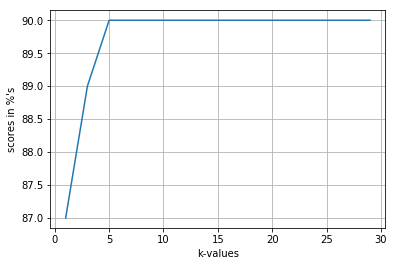

In [72]:
plt.plot(k, scores)
plt.xlabel("k-values")
plt.ylabel("scores in %'s")
plt.grid()
plt.show()

Observation: the plot show's that at k=5 prediction on cross validation data shows maximum score 90%.

In [88]:
knn = KNeighborsClassifier(n_neighbors=5,algorithm='brute')


knn.fit(avg_w2v_train, train_scores)

predicted_labels = []
for j in range(0, 20000, 1000):
    predicted_labels.extend(knn.predict(avg_w2v_test[j: j+1000]))
    
predicted_labels = np.array(predicted_labels)

predicted_labels=predicted_labels.reshape(20000,)
    
confusion_matrix(test_scores, predicted_labels)

array([[  177,  3203],
       [  183, 16437]], dtype=int64)

Observation: In the above confusion matrix,                                                                                  
->the % correctly predicted positive's is 83.6%,  
->the % correctly predicted negative's is 49.1%.

In [73]:
scores = []
k=[]
for i in tqdm(range(1,30,2)):
    
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    
    knn.fit(avg_w2v_train, train_scores)

    predicted_labels = []
    for j in tqdm(range(0, 20000, 1000)):
        predicted_labels.extend(knn.predict(avg_w2v_cv[j: j+1000]))

    predicted_labels = np.array(predicted_labels)

    predicted_labels=predicted_labels.reshape(20000,)
        
    score = f1_score(cv_scores, predicted_labels) * float(100)
    
    scores.append(int(score))
    k.append(i)







  0%|                                                                                           | 0/15 [00:00<?, ?it/s]






  0%|                                                                                           | 0/20 [00:00<?, ?it/s]






  5%|████▏                                                                              | 1/20 [00:17<05:36, 17.70s/it]






 10%|████████▎                                                                          | 2/20 [00:35<05:19, 17.76s/it]






 15%|████████████▍                                                                      | 3/20 [00:53<05:05, 17.95s/it]






 20%|████████████████▌                                                                  | 4/20 [01:12<04:49, 18.11s/it]






 25%|████████████████████▊                                                              | 5/20 [01:30<04:32, 18.18s/it]






 30%|████████████████████████▉                                                          | 6/20 [01:49<04:14, 18.

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [05:39<00:18, 18.01s/it]






100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:56<00:00, 17.73s/it]












 20%|████████████████                                                                | 3/15 [17:51<1:11:43, 358.61s/it]






  0%|                                                                                           | 0/20 [00:00<?, ?it/s]






  5%|████▏                                                                              | 1/20 [00:17<05:31, 17.44s/it]






 10%|████████▎                                                                          | 2/20 [00:35<05:15, 17.52s/it]






 15%|████████████▍                                                                      | 3/20 [00:52<04:58, 17.56s/it]






 20%|████████████████▌                                                                  | 4/20 [01:10<04:42, 17.

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [05:38<01:07, 22.58s/it]






 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [06:15<00:53, 26.68s/it]






 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [07:14<00:36, 36.61s/it]






100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:25<00:00, 46.74s/it]












 40%|████████████████████████████████                                                | 6/15 [38:14<1:00:28, 403.12s/it]






  0%|                                                                                           | 0/20 [00:00<?, ?it/s]






  5%|████▏                                                                              | 1/20 [00:41<13:16, 41.91s/it]






 10%|████████▎                                                                          | 2/20 [01:06<11:01, 36.

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [05:41<02:43, 32.62s/it]






 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [06:19<02:16, 34.10s/it]






 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [06:49<01:38, 32.91s/it]






 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [07:37<01:15, 37.66s/it]






 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [08:27<00:41, 41.15s/it]






100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [09:13<00:00, 42.59s/it]












 60%|████████████████████████████████████████████████                                | 9/15 [1:02:17<45:59, 459.99s/it]






  0%|                                                                                           | 0/20 [00:00<?,

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [03:56<02:07, 18.25s/it]






 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [04:15<01:51, 18.51s/it]






 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [04:34<01:33, 18.71s/it]






 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [04:53<01:14, 18.59s/it]






 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [05:11<00:55, 18.41s/it]






 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [05:29<00:36, 18.31s/it]






 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [05:47<00:18, 18.27s/it]






100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:05<00:00, 18.36s/it

 55%|█████████████████████████████████████████████                                     | 11/20 [03:34<02:54, 19.43s/it]






 60%|█████████████████████████████████████████████████▏                                | 12/20 [03:54<02:35, 19.48s/it]






 65%|█████████████████████████████████████████████████████▎                            | 13/20 [04:14<02:17, 19.57s/it]






 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [04:32<01:56, 19.34s/it]






 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [04:52<01:37, 19.51s/it]






 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [05:12<01:17, 19.40s/it]






 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [05:30<00:57, 19.27s/it]






 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [05:50<00:38, 19.38s/it

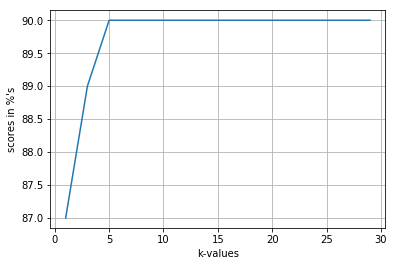

In [74]:
plt.plot(k, scores)
plt.xlabel("k-values")
plt.ylabel("scores in %'s")
plt.grid()
plt.show()

Observation: the plot show's that at k=5 prediction on cross validation data shows maximum score 90%.

In [87]:
knn = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree')


knn.fit(avg_w2v_train, train_scores)

predicted_labels = []
for j in tqdm(range(0, 20000, 1000)):
    predicted_labels.extend(knn.predict(avg_w2v_test[j: j+1000]))
    
predicted_labels = np.array(predicted_labels)

predicted_labels=predicted_labels.reshape(20000,)
    
confusion_matrix(test_scores, predicted_labels)







  0%|                                                                                           | 0/20 [00:00<?, ?it/s]





  5%|████▏                                                                              | 1/20 [00:22<07:00, 22.12s/it]





 10%|████████▎                                                                          | 2/20 [00:54<07:34, 25.26s/it]





 15%|████████████▍                                                                      | 3/20 [01:15<06:48, 24.06s/it]





 20%|████████████████▌                                                                  | 4/20 [01:44<06:45, 25.36s/it]





 25%|████████████████████▊                                                              | 5/20 [02:06<06:04, 24.32s/it]





 30%|████████████████████████▉                                                          | 6/20 [02:35<06:01, 25.82s/it]





 35%|█████████████████████████████                                                      | 7/20 [02:57<05:20, 24.68s/it]

array([[  177,  3203],
       [  183, 16437]], dtype=int64)

Observation: In the above confusion matrix,                                                                                  
->the % correctly predicted positive's is 83.6%,  
->the % correctly predicted negative's is 49.1%.

# tfidf weighted w2v:

In [75]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(train['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model.get_feature_names(), list(model.idf_)))

In [76]:
model = TfidfVectorizer()
tf_idf_matrix_cv = model.fit_transform(cv['CleanedText'].values)
dictionary_cv = dict(zip(model.get_feature_names(), list(model.idf_)))

In [77]:
model = TfidfVectorizer()
tf_idf_matrix_test = model.fit_transform(test['CleanedText'].values)
dictionary_test = dict(zip(model.get_feature_names(), list(model.idf_)))

In [78]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names


tfidf_w2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(train_w2v_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in train_w2v_words:
            vec = train_w2v.wv[word]
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_train.append(sent_vec)
    row += 1







  0%|                                                                                        | 0/60000 [00:00<?, ?it/s]





  0%|                                                                              | 1/60000 [00:00<2:22:36,  7.01it/s]





  0%|                                                                             | 33/60000 [00:00<1:40:46,  9.92it/s]





  0%|                                                                             | 76/60000 [00:00<1:11:12, 14.03it/s]





  0%|▏                                                                             | 109/60000 [00:00<50:43, 19.68it/s]





  0%|▏                                                                             | 133/60000 [00:00<37:05, 26.91it/s]





  0%|▏                                                                             | 155/60000 [00:00<27:41, 36.03it/s]





  0%|▏                                                                             | 182/60000 [00:00<20:31, 48.58it/s]

  3%|██                                                                          | 1606/60000 [00:07<04:27, 218.26it/s]





  3%|██                                                                          | 1629/60000 [00:07<04:57, 196.07it/s]





  3%|██                                                                          | 1656/60000 [00:07<04:33, 213.25it/s]





  3%|██▏                                                                         | 1679/60000 [00:07<04:37, 210.41it/s]





  3%|██▏                                                                         | 1713/60000 [00:07<04:05, 237.21it/s]





  3%|██▏                                                                         | 1754/60000 [00:08<03:34, 271.15it/s]





  3%|██▎                                                                         | 1796/60000 [00:08<03:12, 302.28it/s]





  3%|██▎                                                                         | 1831/60000 [00:08<03:06, 312.03it/s]







  6%|████▌                                                                       | 3564/60000 [00:15<03:11, 294.53it/s]





  6%|████▌                                                                       | 3595/60000 [00:15<03:22, 278.34it/s]





  6%|████▌                                                                       | 3624/60000 [00:15<03:34, 263.19it/s]





  6%|████▋                                                                       | 3656/60000 [00:15<03:29, 268.74it/s]





  6%|████▋                                                                       | 3684/60000 [00:15<03:47, 247.39it/s]





  6%|████▋                                                                       | 3713/60000 [00:15<03:37, 258.30it/s]





  6%|████▋                                                                       | 3740/60000 [00:15<03:39, 256.69it/s]





  6%|████▊                                                                       | 3770/60000 [00:15<03:37, 258.13it/s]







  9%|██████▉                                                                     | 5438/60000 [00:22<05:02, 180.63it/s]





  9%|██████▉                                                                     | 5462/60000 [00:22<04:40, 194.29it/s]





  9%|██████▉                                                                     | 5488/60000 [00:22<04:21, 208.85it/s]





  9%|██████▉                                                                     | 5517/60000 [00:22<04:01, 226.00it/s]





  9%|███████                                                                     | 5547/60000 [00:23<03:45, 241.28it/s]





  9%|███████                                                                     | 5573/60000 [00:23<03:44, 241.99it/s]





  9%|███████                                                                     | 5607/60000 [00:23<03:25, 264.44it/s]





  9%|███████▏                                                                    | 5635/60000 [00:23<03:45, 241.37it/s]







 12%|████████▉                                                                   | 7011/60000 [00:30<04:16, 206.95it/s]





 12%|████████▉                                                                   | 7033/60000 [00:30<04:16, 206.13it/s]





 12%|████████▉                                                                   | 7056/60000 [00:30<04:10, 211.74it/s]





 12%|████████▉                                                                   | 7078/60000 [00:30<04:11, 210.63it/s]





 12%|████████▉                                                                   | 7100/60000 [00:30<04:41, 187.88it/s]





 12%|█████████                                                                   | 7127/60000 [00:30<04:16, 205.93it/s]





 12%|█████████                                                                   | 7150/60000 [00:30<04:09, 211.87it/s]





 12%|█████████                                                                   | 7172/60000 [00:31<04:32, 194.03it/s]







 15%|███████████                                                                 | 8718/60000 [00:37<04:47, 178.58it/s]





 15%|███████████                                                                 | 8738/60000 [00:37<04:38, 184.14it/s]





 15%|███████████                                                                 | 8758/60000 [00:37<04:52, 175.39it/s]





 15%|███████████                                                                 | 8778/60000 [00:38<04:42, 181.01it/s]





 15%|███████████▏                                                                | 8811/60000 [00:38<04:11, 203.66it/s]





 15%|███████████▏                                                                | 8837/60000 [00:38<03:58, 214.73it/s]





 15%|███████████▏                                                                | 8860/60000 [00:38<04:03, 209.69it/s]





 15%|███████████▎                                                                | 8882/60000 [00:38<04:16, 199.02it/s]







 17%|████████████▊                                                              | 10214/60000 [00:45<04:14, 195.92it/s]





 17%|████████████▊                                                              | 10235/60000 [00:45<04:16, 194.01it/s]





 17%|████████████▊                                                              | 10258/60000 [00:45<04:05, 202.64it/s]





 17%|████████████▊                                                              | 10279/60000 [00:45<04:11, 198.01it/s]





 17%|████████████▉                                                              | 10300/60000 [00:45<04:51, 170.72it/s]





 17%|████████████▉                                                              | 10331/60000 [00:45<04:11, 197.22it/s]





 17%|████████████▉                                                              | 10363/60000 [00:45<03:42, 222.76it/s]





 17%|████████████▉                                                              | 10388/60000 [00:45<03:39, 225.78it/s]







 20%|██████████████▋                                                            | 11703/60000 [00:52<04:21, 184.86it/s]





 20%|██████████████▋                                                            | 11726/60000 [00:52<04:07, 195.06it/s]





 20%|██████████████▋                                                            | 11751/60000 [00:52<03:52, 207.93it/s]





 20%|██████████████▋                                                            | 11781/60000 [00:52<03:30, 228.63it/s]





 20%|██████████████▊                                                            | 11808/60000 [00:52<03:22, 238.55it/s]





 20%|██████████████▊                                                            | 11834/60000 [00:53<03:18, 242.74it/s]





 20%|██████████████▊                                                            | 11859/60000 [00:53<03:18, 242.22it/s]





 20%|██████████████▊                                                            | 11884/60000 [00:53<03:27, 232.44it/s]







 22%|████████████████▊                                                          | 13493/60000 [01:00<03:14, 238.62it/s]





 23%|████████████████▉                                                          | 13525/60000 [01:00<03:01, 256.64it/s]





 23%|████████████████▉                                                          | 13552/60000 [01:00<03:04, 252.31it/s]





 23%|████████████████▉                                                          | 13579/60000 [01:00<03:16, 235.69it/s]





 23%|█████████████████                                                          | 13611/60000 [01:00<03:01, 255.77it/s]





 23%|█████████████████                                                          | 13638/60000 [01:00<03:21, 230.51it/s]





 23%|█████████████████                                                          | 13664/60000 [01:00<03:43, 206.95it/s]





 23%|█████████████████                                                          | 13686/60000 [01:00<03:42, 208.41it/s]







 25%|██████████████████▉                                                        | 15139/60000 [01:07<04:14, 176.48it/s]





 25%|██████████████████▉                                                        | 15158/60000 [01:07<04:15, 175.44it/s]





 25%|██████████████████▉                                                        | 15176/60000 [01:07<04:29, 166.63it/s]





 25%|██████████████████▉                                                        | 15194/60000 [01:07<04:24, 169.12it/s]





 25%|███████████████████                                                        | 15212/60000 [01:08<04:22, 170.42it/s]





 25%|███████████████████                                                        | 15237/60000 [01:08<03:59, 186.84it/s]





 25%|███████████████████                                                        | 15266/60000 [01:08<03:36, 207.05it/s]





 25%|███████████████████                                                        | 15296/60000 [01:08<03:16, 227.37it/s]







 28%|████████████████████▉                                                      | 16779/60000 [01:15<04:23, 164.21it/s]





 28%|█████████████████████                                                      | 16802/60000 [01:15<04:00, 179.52it/s]





 28%|█████████████████████                                                      | 16830/60000 [01:15<03:34, 200.86it/s]





 28%|█████████████████████                                                      | 16852/60000 [01:15<03:33, 202.42it/s]





 28%|█████████████████████                                                      | 16874/60000 [01:15<03:50, 187.44it/s]





 28%|█████████████████████                                                      | 16894/60000 [01:15<04:00, 179.39it/s]





 28%|█████████████████████▏                                                     | 16916/60000 [01:15<03:49, 188.09it/s]





 28%|█████████████████████▏                                                     | 16938/60000 [01:16<03:39, 195.74it/s]







 31%|██████████████████████▉                                                    | 18373/60000 [01:22<03:10, 218.36it/s]





 31%|██████████████████████▉                                                    | 18398/60000 [01:22<03:05, 224.70it/s]





 31%|███████████████████████                                                    | 18422/60000 [01:23<03:18, 209.19it/s]





 31%|███████████████████████                                                    | 18446/60000 [01:23<03:11, 217.14it/s]





 31%|███████████████████████                                                    | 18479/60000 [01:23<02:51, 241.57it/s]





 31%|███████████████████████▏                                                   | 18506/60000 [01:23<02:46, 249.28it/s]





 31%|███████████████████████▏                                                   | 18532/60000 [01:23<03:07, 220.82it/s]





 31%|███████████████████████▏                                                   | 18558/60000 [01:23<02:59, 231.12it/s]







 33%|████████████████████████▊                                                  | 19866/60000 [01:30<05:32, 120.65it/s]





 33%|████████████████████████▊                                                  | 19886/60000 [01:30<04:53, 136.75it/s]





 33%|████████████████████████▉                                                  | 19911/60000 [01:30<04:14, 157.44it/s]





 33%|████████████████████████▉                                                  | 19930/60000 [01:31<04:27, 149.65it/s]





 33%|████████████████████████▉                                                  | 19959/60000 [01:31<03:50, 173.90it/s]





 33%|████████████████████████▉                                                  | 19980/60000 [01:31<03:47, 175.67it/s]





 33%|█████████████████████████                                                  | 20004/60000 [01:31<03:34, 186.23it/s]





 33%|█████████████████████████                                                  | 20031/60000 [01:31<03:16, 203.61it/s]







 36%|██████████████████████████▊                                                | 21437/60000 [01:38<02:49, 227.42it/s]





 36%|██████████████████████████▊                                                | 21461/60000 [01:38<02:52, 222.88it/s]





 36%|██████████████████████████▊                                                | 21484/60000 [01:38<02:59, 214.47it/s]





 36%|██████████████████████████▉                                                | 21515/60000 [01:38<02:43, 235.92it/s]





 36%|██████████████████████████▉                                                | 21540/60000 [01:38<02:58, 215.11it/s]





 36%|██████████████████████████▉                                                | 21566/60000 [01:38<02:49, 226.71it/s]





 36%|██████████████████████████▉                                                | 21597/60000 [01:38<02:35, 246.44it/s]





 36%|███████████████████████████                                                | 21623/60000 [01:38<02:39, 240.48it/s]







 38%|████████████████████████████▋                                              | 22961/60000 [01:45<03:31, 175.40it/s]





 38%|████████████████████████████▋                                              | 22980/60000 [01:46<04:00, 153.97it/s]





 38%|████████████████████████████▊                                              | 23002/60000 [01:46<03:39, 168.92it/s]





 38%|████████████████████████████▊                                              | 23027/60000 [01:46<03:17, 187.02it/s]





 38%|████████████████████████████▊                                              | 23049/60000 [01:46<03:13, 191.12it/s]





 38%|████████████████████████████▊                                              | 23078/60000 [01:46<02:55, 209.80it/s]





 39%|████████████████████████████▉                                              | 23101/60000 [01:46<02:54, 210.90it/s]





 39%|████████████████████████████▉                                              | 23125/60000 [01:46<02:49, 217.24it/s]







 41%|██████████████████████████████▌                                            | 24490/60000 [01:53<03:04, 192.10it/s]





 41%|██████████████████████████████▋                                            | 24517/60000 [01:53<02:48, 210.18it/s]





 41%|██████████████████████████████▋                                            | 24540/60000 [01:53<02:59, 197.85it/s]





 41%|██████████████████████████████▋                                            | 24568/60000 [01:53<02:44, 215.08it/s]





 41%|██████████████████████████████▋                                            | 24592/60000 [01:53<02:47, 211.61it/s]





 41%|██████████████████████████████▊                                            | 24618/60000 [01:53<02:39, 221.42it/s]





 41%|██████████████████████████████▊                                            | 24648/60000 [01:54<02:28, 238.17it/s]





 41%|██████████████████████████████▊                                            | 24673/60000 [01:54<02:55, 201.30it/s]







 44%|████████████████████████████████▋                                          | 26121/60000 [02:00<03:23, 166.62it/s]





 44%|████████████████████████████████▋                                          | 26140/60000 [02:01<03:17, 171.73it/s]





 44%|████████████████████████████████▋                                          | 26160/60000 [02:01<03:09, 178.50it/s]





 44%|████████████████████████████████▋                                          | 26188/60000 [02:01<02:49, 199.16it/s]





 44%|████████████████████████████████▊                                          | 26221/60000 [02:01<02:30, 224.79it/s]





 44%|████████████████████████████████▊                                          | 26246/60000 [02:01<02:26, 230.06it/s]





 44%|████████████████████████████████▊                                          | 26271/60000 [02:01<02:40, 210.34it/s]





 44%|████████████████████████████████▊                                          | 26296/60000 [02:01<02:32, 220.42it/s]







 46%|██████████████████████████████████▋                                        | 27789/60000 [02:08<02:17, 234.59it/s]





 46%|██████████████████████████████████▊                                        | 27813/60000 [02:08<02:31, 212.57it/s]





 46%|██████████████████████████████████▊                                        | 27835/60000 [02:08<02:44, 195.37it/s]





 46%|██████████████████████████████████▊                                        | 27856/60000 [02:08<02:48, 190.73it/s]





 46%|██████████████████████████████████▊                                        | 27884/60000 [02:08<02:33, 209.09it/s]





 47%|██████████████████████████████████▉                                        | 27909/60000 [02:08<02:26, 218.60it/s]





 47%|██████████████████████████████████▉                                        | 27932/60000 [02:09<02:27, 217.35it/s]





 47%|██████████████████████████████████▉                                        | 27965/60000 [02:09<02:13, 240.43it/s]







 49%|████████████████████████████████████▉                                      | 29539/60000 [02:15<02:01, 250.77it/s]





 49%|████████████████████████████████████▉                                      | 29565/60000 [02:15<02:22, 212.94it/s]





 49%|████████████████████████████████████▉                                      | 29588/60000 [02:16<02:29, 202.99it/s]





 49%|█████████████████████████████████████                                      | 29613/60000 [02:16<02:21, 214.17it/s]





 49%|█████████████████████████████████████                                      | 29651/60000 [02:16<02:03, 246.08it/s]





 49%|█████████████████████████████████████                                      | 29678/60000 [02:16<02:00, 250.88it/s]





 50%|█████████████████████████████████████▏                                     | 29711/60000 [02:16<01:52, 269.18it/s]





 50%|█████████████████████████████████████▏                                     | 29740/60000 [02:16<02:07, 237.53it/s]







 52%|███████████████████████████████████████                                    | 31217/60000 [02:23<02:32, 188.58it/s]





 52%|███████████████████████████████████████                                    | 31237/60000 [02:23<02:55, 163.77it/s]





 52%|███████████████████████████████████████                                    | 31256/60000 [02:23<02:56, 163.27it/s]





 52%|███████████████████████████████████████                                    | 31279/60000 [02:23<02:41, 178.32it/s]





 52%|███████████████████████████████████████                                    | 31299/60000 [02:24<02:45, 172.99it/s]





 52%|███████████████████████████████████████▏                                   | 31329/60000 [02:24<02:26, 196.32it/s]





 52%|███████████████████████████████████████▏                                   | 31357/60000 [02:24<02:13, 214.80it/s]





 52%|███████████████████████████████████████▏                                   | 31387/60000 [02:24<02:02, 234.12it/s]







 55%|████████████████████████████████████████▉                                  | 32716/60000 [02:31<02:04, 218.50it/s]





 55%|████████████████████████████████████████▉                                  | 32740/60000 [02:31<02:01, 224.08it/s]





 55%|████████████████████████████████████████▉                                  | 32763/60000 [02:31<02:16, 199.59it/s]





 55%|████████████████████████████████████████▉                                  | 32790/60000 [02:31<02:06, 215.64it/s]





 55%|█████████████████████████████████████████                                  | 32813/60000 [02:31<02:09, 210.30it/s]





 55%|█████████████████████████████████████████                                  | 32835/60000 [02:32<02:29, 181.66it/s]





 55%|█████████████████████████████████████████                                  | 32856/60000 [02:32<02:27, 184.00it/s]





 55%|█████████████████████████████████████████                                  | 32889/60000 [02:32<02:08, 211.05it/s]







 57%|██████████████████████████████████████████▊                                | 34266/60000 [02:39<02:29, 172.23it/s]





 57%|██████████████████████████████████████████▊                                | 34285/60000 [02:39<02:25, 177.08it/s]





 57%|██████████████████████████████████████████▉                                | 34305/60000 [02:39<02:23, 179.32it/s]





 57%|██████████████████████████████████████████▉                                | 34327/60000 [02:39<02:15, 189.50it/s]





 57%|██████████████████████████████████████████▉                                | 34348/60000 [02:39<02:13, 192.15it/s]





 57%|██████████████████████████████████████████▉                                | 34368/60000 [02:39<02:17, 186.36it/s]





 57%|██████████████████████████████████████████▉                                | 34388/60000 [02:39<02:18, 185.37it/s]





 57%|███████████████████████████████████████████                                | 34407/60000 [02:39<02:21, 180.24it/s]







 60%|████████████████████████████████████████████▋                              | 35721/60000 [02:46<02:35, 156.14it/s]





 60%|████████████████████████████████████████████▋                              | 35739/60000 [02:46<02:46, 145.40it/s]





 60%|████████████████████████████████████████████▋                              | 35759/60000 [02:46<02:33, 158.10it/s]





 60%|████████████████████████████████████████████▋                              | 35778/60000 [02:46<02:29, 162.54it/s]





 60%|████████████████████████████████████████████▊                              | 35800/60000 [02:47<02:18, 175.21it/s]





 60%|████████████████████████████████████████████▊                              | 35828/60000 [02:47<02:03, 195.83it/s]





 60%|████████████████████████████████████████████▊                              | 35850/60000 [02:47<02:13, 180.29it/s]





 60%|████████████████████████████████████████████▊                              | 35870/60000 [02:47<02:10, 185.41it/s]







 62%|██████████████████████████████████████████████▍                            | 37133/60000 [02:54<01:58, 192.55it/s]





 62%|██████████████████████████████████████████████▍                            | 37158/60000 [02:54<01:50, 206.43it/s]





 62%|██████████████████████████████████████████████▍                            | 37180/60000 [02:54<02:20, 162.55it/s]





 62%|██████████████████████████████████████████████▍                            | 37199/60000 [02:54<02:21, 161.39it/s]





 62%|██████████████████████████████████████████████▌                            | 37234/60000 [02:54<01:58, 191.34it/s]





 62%|██████████████████████████████████████████████▌                            | 37257/60000 [02:54<01:56, 195.99it/s]





 62%|██████████████████████████████████████████████▌                            | 37280/60000 [02:55<01:55, 196.30it/s]





 62%|██████████████████████████████████████████████▋                            | 37302/60000 [02:55<01:55, 196.23it/s]







 64%|████████████████████████████████████████████████▏                          | 38539/60000 [03:02<02:07, 168.25it/s]





 64%|████████████████████████████████████████████████▏                          | 38557/60000 [03:02<02:07, 168.38it/s]





 64%|████████████████████████████████████████████████▏                          | 38575/60000 [03:02<02:25, 147.04it/s]





 64%|████████████████████████████████████████████████▏                          | 38591/60000 [03:02<02:23, 149.13it/s]





 64%|████████████████████████████████████████████████▎                          | 38608/60000 [03:02<02:18, 154.31it/s]





 64%|████████████████████████████████████████████████▎                          | 38630/60000 [03:02<02:06, 169.21it/s]





 64%|████████████████████████████████████████████████▎                          | 38656/60000 [03:02<01:54, 186.28it/s]





 64%|████████████████████████████████████████████████▎                          | 38676/60000 [03:03<01:55, 185.07it/s]







 67%|█████████████████████████████████████████████████▉                         | 39980/60000 [03:09<01:41, 196.56it/s]





 67%|██████████████████████████████████████████████████                         | 40001/60000 [03:09<02:00, 166.34it/s]





 67%|██████████████████████████████████████████████████                         | 40029/60000 [03:10<01:45, 188.74it/s]





 67%|██████████████████████████████████████████████████                         | 40050/60000 [03:10<01:55, 172.32it/s]





 67%|██████████████████████████████████████████████████                         | 40069/60000 [03:10<01:54, 173.52it/s]





 67%|██████████████████████████████████████████████████                         | 40088/60000 [03:10<02:02, 163.17it/s]





 67%|██████████████████████████████████████████████████▏                        | 40106/60000 [03:10<02:02, 162.12it/s]





 67%|██████████████████████████████████████████████████▏                        | 40123/60000 [03:10<02:05, 158.74it/s]







 69%|███████████████████████████████████████████████████▋                       | 41352/60000 [03:17<02:10, 142.40it/s]





 69%|███████████████████████████████████████████████████▋                       | 41370/60000 [03:17<02:03, 150.68it/s]





 69%|███████████████████████████████████████████████████▋                       | 41387/60000 [03:17<02:03, 150.73it/s]





 69%|███████████████████████████████████████████████████▊                       | 41404/60000 [03:17<02:04, 149.18it/s]





 69%|███████████████████████████████████████████████████▊                       | 41422/60000 [03:18<01:59, 155.74it/s]





 69%|███████████████████████████████████████████████████▊                       | 41439/60000 [03:18<01:59, 155.08it/s]





 69%|███████████████████████████████████████████████████▊                       | 41455/60000 [03:18<02:01, 152.62it/s]





 69%|███████████████████████████████████████████████████▊                       | 41477/60000 [03:18<01:51, 166.64it/s]







 71%|█████████████████████████████████████████████████████▍                     | 42737/60000 [03:25<01:20, 215.23it/s]





 71%|█████████████████████████████████████████████████████▍                     | 42760/60000 [03:25<01:25, 200.70it/s]





 71%|█████████████████████████████████████████████████████▍                     | 42782/60000 [03:25<01:27, 196.09it/s]





 71%|█████████████████████████████████████████████████████▌                     | 42804/60000 [03:25<01:25, 201.10it/s]





 71%|█████████████████████████████████████████████████████▌                     | 42825/60000 [03:25<01:41, 168.99it/s]





 71%|█████████████████████████████████████████████████████▌                     | 42851/60000 [03:25<01:30, 188.52it/s]





 71%|█████████████████████████████████████████████████████▌                     | 42876/60000 [03:25<01:24, 203.17it/s]





 71%|█████████████████████████████████████████████████████▌                     | 42898/60000 [03:25<01:24, 201.26it/s]







 74%|███████████████████████████████████████████████████████▎                   | 44266/60000 [03:32<01:30, 173.75it/s]





 74%|███████████████████████████████████████████████████████▎                   | 44285/60000 [03:32<01:39, 157.44it/s]





 74%|███████████████████████████████████████████████████████▍                   | 44304/60000 [03:33<01:34, 165.86it/s]





 74%|███████████████████████████████████████████████████████▍                   | 44337/60000 [03:33<01:20, 194.18it/s]





 74%|███████████████████████████████████████████████████████▍                   | 44363/60000 [03:33<01:14, 209.26it/s]





 74%|███████████████████████████████████████████████████████▍                   | 44387/60000 [03:33<01:11, 217.19it/s]





 74%|███████████████████████████████████████████████████████▌                   | 44411/60000 [03:33<01:12, 215.90it/s]





 74%|███████████████████████████████████████████████████████▌                   | 44434/60000 [03:33<01:13, 212.22it/s]







 77%|█████████████████████████████████████████████████████████▍                 | 45911/60000 [03:40<01:04, 217.60it/s]





 77%|█████████████████████████████████████████████████████████▍                 | 45934/60000 [03:40<01:03, 220.71it/s]





 77%|█████████████████████████████████████████████████████████▍                 | 45957/60000 [03:40<01:09, 201.87it/s]





 77%|█████████████████████████████████████████████████████████▍                 | 45978/60000 [03:40<01:11, 194.76it/s]





 77%|█████████████████████████████████████████████████████████▌                 | 46003/60000 [03:40<01:07, 207.69it/s]





 77%|█████████████████████████████████████████████████████████▌                 | 46027/60000 [03:40<01:06, 209.24it/s]





 77%|█████████████████████████████████████████████████████████▌                 | 46058/60000 [03:41<01:00, 231.20it/s]





 77%|█████████████████████████████████████████████████████████▌                 | 46092/60000 [03:41<00:54, 255.60it/s]







 80%|███████████████████████████████████████████████████████████▋               | 47735/60000 [03:47<01:02, 195.25it/s]





 80%|███████████████████████████████████████████████████████████▋               | 47762/60000 [03:47<00:59, 207.20it/s]





 80%|███████████████████████████████████████████████████████████▋               | 47784/60000 [03:48<01:00, 200.67it/s]





 80%|███████████████████████████████████████████████████████████▊               | 47813/60000 [03:48<00:55, 219.24it/s]





 80%|███████████████████████████████████████████████████████████▊               | 47840/60000 [03:48<00:52, 231.31it/s]





 80%|███████████████████████████████████████████████████████████▊               | 47873/60000 [03:48<00:47, 253.10it/s]





 80%|███████████████████████████████████████████████████████████▉               | 47900/60000 [03:48<00:48, 251.66it/s]





 80%|███████████████████████████████████████████████████████████▉               | 47929/60000 [03:48<00:46, 260.83it/s]







 83%|█████████████████████████████████████████████████████████████▉             | 49516/60000 [03:55<00:40, 258.23it/s]





 83%|█████████████████████████████████████████████████████████████▉             | 49544/60000 [03:55<00:39, 263.11it/s]





 83%|█████████████████████████████████████████████████████████████▉             | 49572/60000 [03:55<00:40, 258.88it/s]





 83%|█████████████████████████████████████████████████████████████▉             | 49599/60000 [03:55<00:43, 239.03it/s]





 83%|██████████████████████████████████████████████████████████████             | 49627/60000 [03:55<00:41, 249.52it/s]





 83%|██████████████████████████████████████████████████████████████             | 49660/60000 [03:55<00:38, 269.05it/s]





 83%|██████████████████████████████████████████████████████████████             | 49699/60000 [03:55<00:34, 295.14it/s]





 83%|██████████████████████████████████████████████████████████████▏            | 49732/60000 [03:55<00:33, 303.76it/s]







 86%|████████████████████████████████████████████████████████████████▎          | 51415/60000 [04:02<00:40, 212.73it/s]





 86%|████████████████████████████████████████████████████████████████▎          | 51439/60000 [04:03<00:40, 213.36it/s]





 86%|████████████████████████████████████████████████████████████████▎          | 51462/60000 [04:03<00:40, 210.49it/s]





 86%|████████████████████████████████████████████████████████████████▎          | 51494/60000 [04:03<00:36, 233.18it/s]





 86%|████████████████████████████████████████████████████████████████▍          | 51519/60000 [04:03<00:38, 217.69it/s]





 86%|████████████████████████████████████████████████████████████████▍          | 51546/60000 [04:03<00:36, 230.68it/s]





 86%|████████████████████████████████████████████████████████████████▍          | 51571/60000 [04:03<00:39, 211.24it/s]





 86%|████████████████████████████████████████████████████████████████▌          | 51602/60000 [04:03<00:36, 227.05it/s]







 89%|██████████████████████████████████████████████████████████████████▌        | 53288/60000 [04:10<00:23, 284.63it/s]





 89%|██████████████████████████████████████████████████████████████████▋        | 53319/60000 [04:10<00:22, 291.59it/s]





 89%|██████████████████████████████████████████████████████████████████▋        | 53349/60000 [04:10<00:23, 278.75it/s]





 89%|██████████████████████████████████████████████████████████████████▋        | 53378/60000 [04:10<00:24, 268.94it/s]





 89%|██████████████████████████████████████████████████████████████████▊        | 53406/60000 [04:10<00:25, 254.59it/s]





 89%|██████████████████████████████████████████████████████████████████▊        | 53445/60000 [04:11<00:23, 283.99it/s]





 89%|██████████████████████████████████████████████████████████████████▊        | 53475/60000 [04:11<00:23, 283.12it/s]





 89%|██████████████████████████████████████████████████████████████████▉        | 53505/60000 [04:11<00:22, 285.74it/s]







 92%|████████████████████████████████████████████████████████████████████▊      | 55055/60000 [04:17<00:24, 204.38it/s]





 92%|████████████████████████████████████████████████████████████████████▊      | 55077/60000 [04:18<00:26, 184.18it/s]





 92%|████████████████████████████████████████████████████████████████████▊      | 55097/60000 [04:18<00:26, 181.86it/s]





 92%|████████████████████████████████████████████████████████████████████▉      | 55117/60000 [04:18<00:28, 172.36it/s]





 92%|████████████████████████████████████████████████████████████████████▉      | 55142/60000 [04:18<00:25, 189.96it/s]





 92%|████████████████████████████████████████████████████████████████████▉      | 55168/60000 [04:18<00:23, 206.06it/s]





 92%|█████████████████████████████████████████████████████████████████████      | 55205/60000 [04:18<00:20, 237.31it/s]





 92%|█████████████████████████████████████████████████████████████████████      | 55232/60000 [04:18<00:20, 230.69it/s]







 95%|██████████████████████████████████████████████████████████████████████▉    | 56706/60000 [04:25<00:16, 200.19it/s]





 95%|██████████████████████████████████████████████████████████████████████▉    | 56728/60000 [04:25<00:16, 198.39it/s]





 95%|██████████████████████████████████████████████████████████████████████▉    | 56749/60000 [04:25<00:16, 197.62it/s]





 95%|██████████████████████████████████████████████████████████████████████▉    | 56772/60000 [04:25<00:15, 203.21it/s]





 95%|██████████████████████████████████████████████████████████████████████▉    | 56797/60000 [04:25<00:15, 203.38it/s]





 95%|███████████████████████████████████████████████████████████████████████    | 56820/60000 [04:25<00:15, 204.68it/s]





 95%|███████████████████████████████████████████████████████████████████████    | 56841/60000 [04:26<00:15, 201.09it/s]





 95%|███████████████████████████████████████████████████████████████████████    | 56873/60000 [04:26<00:13, 225.97it/s]







 97%|████████████████████████████████████████████████████████████████████████▉  | 58340/60000 [04:32<00:06, 256.08it/s]





 97%|████████████████████████████████████████████████████████████████████████▉  | 58368/60000 [04:32<00:06, 248.36it/s]





 97%|████████████████████████████████████████████████████████████████████████▉  | 58394/60000 [04:32<00:06, 237.48it/s]





 97%|█████████████████████████████████████████████████████████████████████████  | 58422/60000 [04:33<00:06, 247.33it/s]





 97%|█████████████████████████████████████████████████████████████████████████  | 58448/60000 [04:33<00:06, 247.62it/s]





 97%|█████████████████████████████████████████████████████████████████████████  | 58480/60000 [04:33<00:05, 264.50it/s]





 98%|█████████████████████████████████████████████████████████████████████████▏ | 58508/60000 [04:33<00:05, 263.86it/s]





 98%|█████████████████████████████████████████████████████████████████████████▏ | 58546/60000 [04:33<00:05, 290.01it/s]







In [79]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names

tfidf_w2v_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(cv_w2v_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in cv_w2v_words:
            vec = cv_w2v.wv[word]
            tf_idf = dictionary_cv[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_cv.append(sent_vec)
    row += 1







  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]





  0%|                                                                              | 23/20000 [00:00<01:27, 228.33it/s]





  0%|▏                                                                             | 64/20000 [00:00<01:15, 262.97it/s]





  1%|▍                                                                            | 105/20000 [00:00<01:07, 294.21it/s]





  1%|▌                                                                            | 135/20000 [00:00<01:07, 292.70it/s]





  1%|▌                                                                            | 161/20000 [00:00<01:11, 276.90it/s]





  1%|▊                                                                            | 197/20000 [00:00<01:06, 296.97it/s]





  1%|▊                                                                            | 226/20000 [00:00<01:17, 254.75it/s]

 11%|████████▋                                                                   | 2279/20000 [00:07<00:56, 311.14it/s]





 12%|████████▊                                                                   | 2313/20000 [00:07<00:55, 316.84it/s]





 12%|████████▉                                                                   | 2346/20000 [00:07<00:55, 319.07it/s]





 12%|█████████                                                                   | 2379/20000 [00:07<00:57, 305.96it/s]





 12%|█████████▏                                                                  | 2414/20000 [00:07<00:55, 317.75it/s]





 12%|█████████▎                                                                  | 2459/20000 [00:07<00:50, 347.08it/s]





 12%|█████████▍                                                                  | 2495/20000 [00:07<00:54, 320.29it/s]





 13%|█████████▋                                                                  | 2537/20000 [00:07<00:51, 340.06it/s]







 22%|████████████████▉                                                           | 4441/20000 [00:14<00:59, 263.22it/s]





 22%|█████████████████                                                           | 4478/20000 [00:14<00:53, 287.68it/s]





 23%|█████████████████▏                                                          | 4509/20000 [00:14<00:53, 287.72it/s]





 23%|█████████████████▏                                                          | 4539/20000 [00:14<00:55, 276.26it/s]





 23%|█████████████████▎                                                          | 4572/20000 [00:14<00:53, 289.89it/s]





 23%|█████████████████▌                                                          | 4609/20000 [00:15<00:49, 308.69it/s]





 23%|█████████████████▋                                                          | 4661/20000 [00:15<00:43, 348.91it/s]





 23%|█████████████████▊                                                          | 4699/20000 [00:15<00:48, 318.46it/s]







 33%|█████████████████████████                                                   | 6581/20000 [00:21<00:49, 269.66it/s]





 33%|█████████████████████████▏                                                  | 6613/20000 [00:21<00:48, 276.26it/s]





 33%|█████████████████████████▏                                                  | 6642/20000 [00:22<00:52, 254.99it/s]





 33%|█████████████████████████▎                                                  | 6669/20000 [00:22<00:51, 257.65it/s]





 34%|█████████████████████████▍                                                  | 6701/20000 [00:22<00:48, 271.75it/s]





 34%|█████████████████████████▌                                                  | 6736/20000 [00:22<00:46, 287.19it/s]





 34%|█████████████████████████▋                                                  | 6766/20000 [00:22<00:47, 280.55it/s]





 34%|█████████████████████████▊                                                  | 6795/20000 [00:22<00:46, 281.89it/s]







 44%|█████████████████████████████████▏                                          | 8718/20000 [00:28<00:43, 260.95it/s]





 44%|█████████████████████████████████▏                                          | 8745/20000 [00:29<00:44, 251.66it/s]





 44%|█████████████████████████████████▎                                          | 8771/20000 [00:29<00:46, 241.56it/s]





 44%|█████████████████████████████████▍                                          | 8796/20000 [00:29<00:51, 216.39it/s]





 44%|█████████████████████████████████▌                                          | 8836/20000 [00:29<00:44, 250.14it/s]





 44%|█████████████████████████████████▋                                          | 8875/20000 [00:29<00:41, 268.88it/s]





 45%|█████████████████████████████████▊                                          | 8913/20000 [00:29<00:37, 292.88it/s]





 45%|█████████████████████████████████▉                                          | 8945/20000 [00:29<00:38, 288.58it/s]







 54%|████████████████████████████████████████▌                                  | 10821/20000 [00:36<00:30, 299.45it/s]





 54%|████████████████████████████████████████▋                                  | 10852/20000 [00:36<00:30, 298.41it/s]





 54%|████████████████████████████████████████▊                                  | 10886/20000 [00:36<00:29, 306.19it/s]





 55%|████████████████████████████████████████▉                                  | 10918/20000 [00:36<00:31, 290.23it/s]





 55%|█████████████████████████████████████████                                  | 10962/20000 [00:36<00:28, 321.31it/s]





 55%|█████████████████████████████████████████▏                                 | 10996/20000 [00:36<00:27, 325.53it/s]





 55%|█████████████████████████████████████████▍                                 | 11035/20000 [00:36<00:26, 342.29it/s]





 55%|█████████████████████████████████████████▌                                 | 11072/20000 [00:37<00:25, 348.93it/s]







 63%|███████████████████████████████████████████████▎                           | 12630/20000 [00:43<00:29, 253.89it/s]





 63%|███████████████████████████████████████████████▍                           | 12657/20000 [00:43<00:31, 232.10it/s]





 63%|███████████████████████████████████████████████▌                           | 12682/20000 [00:44<00:32, 223.10it/s]





 64%|███████████████████████████████████████████████▋                           | 12709/20000 [00:44<00:31, 233.70it/s]





 64%|███████████████████████████████████████████████▋                           | 12733/20000 [00:44<00:30, 235.38it/s]





 64%|███████████████████████████████████████████████▊                           | 12764/20000 [00:44<00:28, 250.48it/s]





 64%|███████████████████████████████████████████████▉                           | 12798/20000 [00:44<00:27, 263.00it/s]





 64%|████████████████████████████████████████████████                           | 12831/20000 [00:44<00:25, 278.13it/s]







 73%|███████████████████████████████████████████████████████                    | 14687/20000 [00:51<00:16, 327.69it/s]





 74%|███████████████████████████████████████████████████████▏                   | 14722/20000 [00:51<00:16, 325.95it/s]





 74%|███████████████████████████████████████████████████████▎                   | 14757/20000 [00:51<00:17, 306.85it/s]





 74%|███████████████████████████████████████████████████████▍                   | 14795/20000 [00:51<00:16, 325.05it/s]





 74%|███████████████████████████████████████████████████████▌                   | 14829/20000 [00:51<00:15, 327.26it/s]





 74%|███████████████████████████████████████████████████████▊                   | 14867/20000 [00:51<00:15, 340.81it/s]





 75%|███████████████████████████████████████████████████████▉                   | 14902/20000 [00:51<00:15, 325.61it/s]





 75%|████████████████████████████████████████████████████████                   | 14936/20000 [00:51<00:15, 323.47it/s]







 85%|███████████████████████████████████████████████████████████████▌           | 16948/20000 [00:58<00:13, 231.69it/s]





 85%|███████████████████████████████████████████████████████████████▋           | 16975/20000 [00:58<00:12, 234.00it/s]





 85%|███████████████████████████████████████████████████████████████▋           | 16999/20000 [00:58<00:14, 213.36it/s]





 85%|███████████████████████████████████████████████████████████████▊           | 17023/20000 [00:58<00:13, 220.27it/s]





 85%|███████████████████████████████████████████████████████████████▉           | 17046/20000 [00:58<00:13, 211.60it/s]





 85%|████████████████████████████████████████████████████████████████           | 17076/20000 [00:58<00:12, 231.72it/s]





 86%|████████████████████████████████████████████████████████████████▏          | 17109/20000 [00:58<00:11, 252.33it/s]





 86%|████████████████████████████████████████████████████████████████▎          | 17136/20000 [00:59<00:11, 251.47it/s]







 96%|███████████████████████████████████████████████████████████████████████▉   | 19179/20000 [01:05<00:03, 255.02it/s]





 96%|████████████████████████████████████████████████████████████████████████   | 19209/20000 [01:05<00:02, 266.11it/s]





 96%|████████████████████████████████████████████████████████████████████████▏  | 19237/20000 [01:05<00:02, 264.98it/s]





 96%|████████████████████████████████████████████████████████████████████████▏  | 19266/20000 [01:05<00:02, 271.43it/s]





 96%|████████████████████████████████████████████████████████████████████████▎  | 19294/20000 [01:06<00:02, 272.56it/s]





 97%|████████████████████████████████████████████████████████████████████████▌  | 19338/20000 [01:06<00:02, 306.09it/s]





 97%|████████████████████████████████████████████████████████████████████████▋  | 19371/20000 [01:06<00:02, 301.56it/s]





 97%|████████████████████████████████████████████████████████████████████████▊  | 19403/20000 [01:06<00:01, 306.00it/s]







In [80]:
tfidf_feat = model.get_feature_names()
tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(test_w2v_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in test_w2v_words:
            vec = test_w2v.wv[word]
            tf_idf = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_test.append(sent_vec)
    row += 1







  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]





  0%|                                                                              | 17/20000 [00:00<01:59, 167.12it/s]





  0%|▏                                                                             | 51/20000 [00:00<01:41, 196.95it/s]





  0%|▎                                                                             | 79/20000 [00:00<01:32, 215.78it/s]





  1%|▍                                                                            | 120/20000 [00:00<01:19, 251.18it/s]





  1%|▋                                                                            | 164/20000 [00:00<01:09, 286.76it/s]





  1%|▊                                                                            | 200/20000 [00:00<01:06, 296.57it/s]





  1%|▉                                                                            | 234/20000 [00:00<01:04, 307.35it/s]

 12%|█████████                                                                   | 2369/20000 [00:07<01:06, 266.67it/s]





 12%|█████████                                                                   | 2398/20000 [00:07<01:04, 271.54it/s]





 12%|█████████▏                                                                  | 2428/20000 [00:07<01:05, 269.19it/s]





 12%|█████████▎                                                                  | 2460/20000 [00:07<01:03, 275.91it/s]





 12%|█████████▍                                                                  | 2489/20000 [00:07<01:02, 279.40it/s]





 13%|█████████▌                                                                  | 2518/20000 [00:07<01:06, 261.37it/s]





 13%|█████████▋                                                                  | 2545/20000 [00:07<01:15, 230.98it/s]





 13%|█████████▊                                                                  | 2571/20000 [00:07<01:13, 237.85it/s]







 23%|█████████████████▎                                                          | 4556/20000 [00:14<00:56, 273.15it/s]





 23%|█████████████████▍                                                          | 4589/20000 [00:14<00:53, 285.99it/s]





 23%|█████████████████▌                                                          | 4619/20000 [00:14<00:55, 274.76it/s]





 23%|█████████████████▋                                                          | 4661/20000 [00:14<00:50, 306.07it/s]





 23%|█████████████████▊                                                          | 4694/20000 [00:14<00:49, 311.35it/s]





 24%|█████████████████▉                                                          | 4731/20000 [00:14<00:46, 325.82it/s]





 24%|██████████████████                                                          | 4765/20000 [00:14<00:47, 321.32it/s]





 24%|██████████████████▏                                                         | 4798/20000 [00:15<00:49, 310.00it/s]







 34%|█████████████████████████▍                                                  | 6707/20000 [00:21<00:41, 322.08it/s]





 34%|█████████████████████████▌                                                  | 6740/20000 [00:21<00:41, 322.77it/s]





 34%|█████████████████████████▊                                                  | 6786/20000 [00:21<00:37, 353.90it/s]





 34%|█████████████████████████▉                                                  | 6837/20000 [00:21<00:34, 386.39it/s]





 34%|██████████████████████████▏                                                 | 6878/20000 [00:22<00:37, 346.24it/s]





 35%|██████████████████████████▎                                                 | 6915/20000 [00:22<00:38, 341.60it/s]





 35%|██████████████████████████▍                                                 | 6951/20000 [00:22<00:42, 305.72it/s]





 35%|██████████████████████████▌                                                 | 6991/20000 [00:22<00:39, 325.99it/s]







 45%|██████████████████████████████████                                          | 8972/20000 [00:28<00:39, 281.54it/s]





 45%|██████████████████████████████████▏                                         | 9013/20000 [00:29<00:36, 299.39it/s]





 45%|██████████████████████████████████▎                                         | 9044/20000 [00:29<00:39, 278.28it/s]





 45%|██████████████████████████████████▍                                         | 9073/20000 [00:29<00:39, 273.95it/s]





 46%|██████████████████████████████████▌                                         | 9109/20000 [00:29<00:37, 293.86it/s]





 46%|██████████████████████████████████▊                                         | 9147/20000 [00:29<00:35, 308.61it/s]





 46%|██████████████████████████████████▉                                         | 9189/20000 [00:29<00:32, 334.70it/s]





 46%|███████████████████████████████████                                         | 9224/20000 [00:29<00:34, 314.32it/s]







 57%|██████████████████████████████████████████▋                                | 11395/20000 [00:36<00:28, 299.63it/s]





 57%|██████████████████████████████████████████▊                                | 11429/20000 [00:36<00:27, 310.07it/s]





 57%|██████████████████████████████████████████▉                                | 11464/20000 [00:36<00:26, 319.97it/s]





 58%|███████████████████████████████████████████▏                               | 11503/20000 [00:36<00:25, 337.54it/s]





 58%|███████████████████████████████████████████▎                               | 11538/20000 [00:36<00:25, 335.58it/s]





 58%|███████████████████████████████████████████▍                               | 11573/20000 [00:36<00:26, 316.15it/s]





 58%|███████████████████████████████████████████▌                               | 11606/20000 [00:36<00:27, 299.94it/s]





 58%|███████████████████████████████████████████▋                               | 11644/20000 [00:37<00:26, 316.40it/s]







 68%|███████████████████████████████████████████████████                        | 13632/20000 [00:43<00:23, 274.82it/s]





 68%|███████████████████████████████████████████████████▏                       | 13660/20000 [00:43<00:24, 261.14it/s]





 68%|███████████████████████████████████████████████████▎                       | 13687/20000 [00:43<00:24, 261.65it/s]





 69%|███████████████████████████████████████████████████▍                       | 13728/20000 [00:43<00:21, 289.33it/s]





 69%|███████████████████████████████████████████████████▋                       | 13770/20000 [00:43<00:19, 317.15it/s]





 69%|███████████████████████████████████████████████████▊                       | 13806/20000 [00:44<00:18, 328.23it/s]





 69%|███████████████████████████████████████████████████▉                       | 13848/20000 [00:44<00:17, 350.62it/s]





 69%|████████████████████████████████████████████████████                       | 13889/20000 [00:44<00:16, 360.06it/s]







 81%|████████████████████████████████████████████████████████████▊              | 16202/20000 [00:50<00:11, 336.81it/s]





 81%|████████████████████████████████████████████████████████████▉              | 16240/20000 [00:50<00:10, 347.51it/s]





 81%|█████████████████████████████████████████████████████████████              | 16276/20000 [00:50<00:11, 322.68it/s]





 82%|█████████████████████████████████████████████████████████████▏             | 16315/20000 [00:51<00:10, 337.01it/s]





 82%|█████████████████████████████████████████████████████████████▎             | 16350/20000 [00:51<00:11, 319.64it/s]





 82%|█████████████████████████████████████████████████████████████▍             | 16392/20000 [00:51<00:10, 343.70it/s]





 82%|█████████████████████████████████████████████████████████████▋             | 16438/20000 [00:51<00:09, 369.47it/s]





 82%|█████████████████████████████████████████████████████████████▊             | 16480/20000 [00:51<00:09, 375.38it/s]







 93%|██████████████████████████████████████████████████████████████████████     | 18690/20000 [00:57<00:04, 283.61it/s]





 94%|██████████████████████████████████████████████████████████████████████▏    | 18719/20000 [00:58<00:04, 267.58it/s]





 94%|██████████████████████████████████████████████████████████████████████▎    | 18753/20000 [00:58<00:04, 281.78it/s]





 94%|██████████████████████████████████████████████████████████████████████▌    | 18801/20000 [00:58<00:03, 313.62it/s]





 94%|██████████████████████████████████████████████████████████████████████▋    | 18838/20000 [00:58<00:03, 328.01it/s]





 94%|██████████████████████████████████████████████████████████████████████▊    | 18874/20000 [00:58<00:03, 336.30it/s]





 95%|██████████████████████████████████████████████████████████████████████▉    | 18910/20000 [00:58<00:03, 341.39it/s]





 95%|███████████████████████████████████████████████████████████████████████    | 18950/20000 [00:58<00:02, 354.50it/s]







In [81]:
scores = []
k=[]
for i in tqdm(range(1,30,2)):
    
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    knn.fit(tfidf_w2v_train, train_scores)

    predicted_labels = []
    for j in range(0, 20000, 1000):
        predicted_labels.extend(knn.predict(tfidf_w2v_cv[j: j+1000]))
        
    predicted_labels = np.array(predicted_labels)

    predicted_labels=predicted_labels.reshape(20000,)

    score = f1_score(cv_scores, predicted_labels) * float(100)
    
    scores.append(int(score))
    k.append(i)







  0%|                                                                                           | 0/15 [00:00<?, ?it/s]





  7%|█████▌                                                                             | 1/15 [00:47<11:08, 47.72s/it]





 13%|███████████                                                                        | 2/15 [01:40<10:38, 49.11s/it]





 20%|████████████████▌                                                                  | 3/15 [02:48<10:58, 54.84s/it]





 27%|██████████████████████▏                                                            | 4/15 [03:52<10:35, 57.77s/it]





 33%|███████████████████████████▋                                                       | 5/15 [04:58<10:00, 60.04s/it]





 40%|█████████████████████████████████▏                                                 | 6/15 [06:03<09:13, 61.47s/it]





 47%|██████████████████████████████████████▋                                            | 7/15 [07:07<08:19, 62.42s/it]

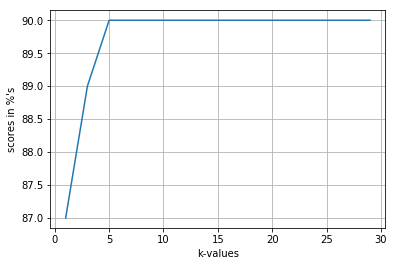

In [82]:
plt.plot(k, scores)
plt.xlabel("k-values")
plt.ylabel("scores in %'s")
plt.grid()
plt.show()

Observation: the plot show's that at k=5 prediction on cross validation data shows maximum score 90%.

In [86]:
knn = KNeighborsClassifier(n_neighbors=5,algorithm='brute')

knn.fit(tfidf_w2v_train, train_scores)

predicted_labels = []
for j in range(0, 20000, 1000):
    predicted_labels.extend(knn.predict(tfidf_w2v_test[j: j+1000]))
    
predicted_labels = np.array(predicted_labels)

predicted_labels=predicted_labels.reshape(20000,)
    
confusion_matrix(test_scores, predicted_labels)

array([[  184,  3196],
       [  156, 16464]], dtype=int64)

Observation: In the above confusion matrix,                                                                                  
->the % correctly predicted positive's is 83.7%,  
->the % correctly predicted negative's is 54.1%.

In [83]:
scores = []
k=[]
for i in tqdm(range(1,30,2)):
    
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    knn.fit(tfidf_w2v_train, train_scores)

    predicted_labels = []
    for j in tqdm(range(0, 20000, 1000)):
        predicted_labels.extend(knn.predict(tfidf_w2v_cv[j: j+1000]))
        
    predicted_labels = np.array(predicted_labels)

    predicted_labels=predicted_labels.reshape(20000,)

    score = f1_score(cv_scores, predicted_labels) * float(100)
    
    scores.append(int(score))
    k.append(i)







  0%|                                                                                           | 0/15 [00:00<?, ?it/s]






  0%|                                                                                           | 0/20 [00:00<?, ?it/s]






  5%|████▏                                                                              | 1/20 [00:15<04:53, 15.44s/it]






 10%|████████▎                                                                          | 2/20 [00:31<04:40, 15.61s/it]






 15%|████████████▍                                                                      | 3/20 [00:46<04:23, 15.52s/it]






 20%|████████████████▌                                                                  | 4/20 [01:02<04:10, 15.63s/it]






 25%|████████████████████▊                                                              | 5/20 [01:19<04:01, 16.10s/it]






 30%|████████████████████████▉                                                          | 6/20 [01:36<03:46, 16.

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [05:14<00:16, 16.55s/it]






100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:30<00:00, 16.55s/it]












 20%|████████████████                                                                | 3/15 [16:24<1:05:22, 326.87s/it]






  0%|                                                                                           | 0/20 [00:00<?, ?it/s]






  5%|████▏                                                                              | 1/20 [00:17<05:25, 17.14s/it]






 10%|████████▎                                                                          | 2/20 [00:33<05:04, 16.89s/it]






 15%|████████████▍                                                                      | 3/20 [00:49<04:44, 16.75s/it]






 20%|████████████████▌                                                                  | 4/20 [01:06<04:27, 16.

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [04:50<00:50, 16.92s/it]






 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [05:07<00:33, 16.98s/it]






 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [05:25<00:17, 17.20s/it]






100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:41<00:00, 17.00s/it]












 40%|████████████████████████████████▊                                                 | 6/15 [33:10<50:00, 333.36s/it]






  0%|                                                                                           | 0/20 [00:00<?, ?it/s]






  5%|████▏                                                                              | 1/20 [00:16<05:12, 16.46s/it]






 10%|████████▎                                                                          | 2/20 [00:33<04:57, 16.

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [04:26<01:30, 18.04s/it]






 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [04:44<01:11, 17.97s/it]






 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [05:01<00:53, 17.91s/it]






 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [05:19<00:35, 17.95s/it]






 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [05:38<00:18, 18.02s/it]






100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:56<00:00, 18.15s/it]












 60%|█████████████████████████████████████████████████▏                                | 9/15 [50:30<34:20, 343.48s/it]






  0%|                                                                                           | 0/20 [00:00<?,

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [03:57<02:03, 17.69s/it]






 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [04:14<01:45, 17.53s/it]






 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [04:31<01:27, 17.44s/it]






 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [04:49<01:09, 17.33s/it]






 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [05:06<00:51, 17.26s/it]






 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [05:22<00:34, 17.10s/it]






 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [05:40<00:17, 17.26s/it]






100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:57<00:00, 17.26s/it

 55%|█████████████████████████████████████████████                                     | 11/20 [03:06<02:31, 16.80s/it]






 60%|█████████████████████████████████████████████████▏                                | 12/20 [03:23<02:14, 16.76s/it]






 65%|█████████████████████████████████████████████████████▎                            | 13/20 [03:40<01:57, 16.81s/it]






 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:56<01:40, 16.74s/it]






 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [04:13<01:23, 16.80s/it]






 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [04:31<01:07, 16.89s/it]






 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [04:47<00:50, 16.73s/it]






 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [05:03<00:33, 16.66s/it

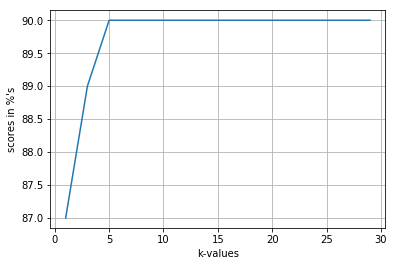

In [84]:
plt.plot(k, scores)
plt.xlabel("k-values")
plt.ylabel("scores in %'s")
plt.grid()
plt.show()

Observation: the plot show's that at k=5 prediction on cross validation data shows maximum score 90%.

In [85]:
knn = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree')

knn.fit(tfidf_w2v_train, train_scores)

predicted_labels = []
for j in range(0, 20000, 1000):
    predicted_labels.extend(knn.predict(tfidf_w2v_test[j: j+1000]))
    
predicted_labels = np.array(predicted_labels)

predicted_labels=predicted_labels.reshape(20000,)
    
confusion_matrix(test_scores, predicted_labels)

array([[  184,  3196],
       [  156, 16464]], dtype=int64)

Observation: In the above confusion matrix,                                                                                  
->the % correctly predicted positive's is 83.7%,  
->the % correctly predicted negative's is 54.1%.

# CONCLUSION:

Let correctly predicted positive rating=P, correctly predicted negative rating=N

In the above table we can see that for tfidf using kd_tree algorithm has more true positive rating and true negative rating with the hyper-parameter=3